In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import utils.paths as plh
#import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import utils.read_utils as hlpread
from itertools import permutations, combinations

# Paths #

In [2]:
PROJECT_ROOT = plh.get_project_root()
PROJECT_ROOT

WindowsPath('F:/github_workspace/employee_access_resource_classifier')

In [3]:
train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
                        
train_data

'F:\\github_workspace\\employee_access_resource_classifier\\data\\prepared\\clean_train.csv'

In [4]:
train = hlpread.read_from_parquet(train_data)

print(train.shape)
train.head()

(30391, 10)


ACTION RESOURCE  MGR_ID ROLE_ROLLUP_1 ROLE_ROLLUP_2 ROLE_DEPTNAME  \
0       1    39353   85475        117961        118300        123472   
1       1    17183    1540        117961        118343        123125   
2       1    36724   14457        118219        118220        117884   
3       1    36135    5396        117961        118343        119993   
4       1    42680    5905        117929        117930        119569   

  ROLE_TITLE ROLE_FAMILY_DESC ROLE_FAMILY ROLE_CODE  
0     117905           117906      290919    117908  
1     118536           118536      308574    118539  
2     117879           267952       19721    117880  
3     118321           240983      290919    118322  
4     119323           123932       19793    119325

In [38]:
train.ACTION.value_counts()

1    28551
0     1840
Name: ACTION, dtype: int64

# Exploratory Data Analysis (EDA) #

  - "RESOURCE" feature should be consider with all other feature. Since "ACCESS" to any thing is based on the "RESOURCE" itself.

### Feature: "RESOURCE" and "ACTION" ###
* Distribution of "ACCESS" action per "RESOURCE".</br>
    Are there "RESOURCE" that all the employee/role have access to ? i.e there are no negative class label for the "RESOURCE"

In [39]:
#train[["RESOURCE","ACTION"]].value_counts().reset_index(name = "COUNT")#.sort_values(by = "RESOURCE").plot(x = "COUNT",  y="RESOURCE",  color='darkblue')
temp_x = pd.crosstab(train['RESOURCE'], train['ACTION']).reset_index().sort_values(by = [0,1])
temp_x.rename_axis(None, axis = 1, inplace = True)

In [40]:
temp_x

RESOURCE   0    1
1      100003   0    1
2      100028   0    1
3      100031   0    1
5      100038   0    1
9      100413   0    1
...       ...  ..  ...
1657    27416  19   18
1518    25993  19  361
488     13878  20  161
844     18072  28   87
1091    20897  42   60

[7518 rows x 3 columns]

In [41]:
temp_x[temp_x[0] == 0].RESOURCE.count()

6384

In [42]:
temp_x[temp_x[1] == 0].RESOURCE.count()

297

In [43]:
#Plot was not clearly visible
#fig = plt.figure(num = 1, 
#                 figsize = (25,10), 
#                 dpi = 200, 
#                 clear = True,
#                 constrained_layout =  True)
#ax = temp_x.plot(kind = 'bar', stacked = True, color = ['steelblue', 'red'], mark_right = True)
#fig.show()

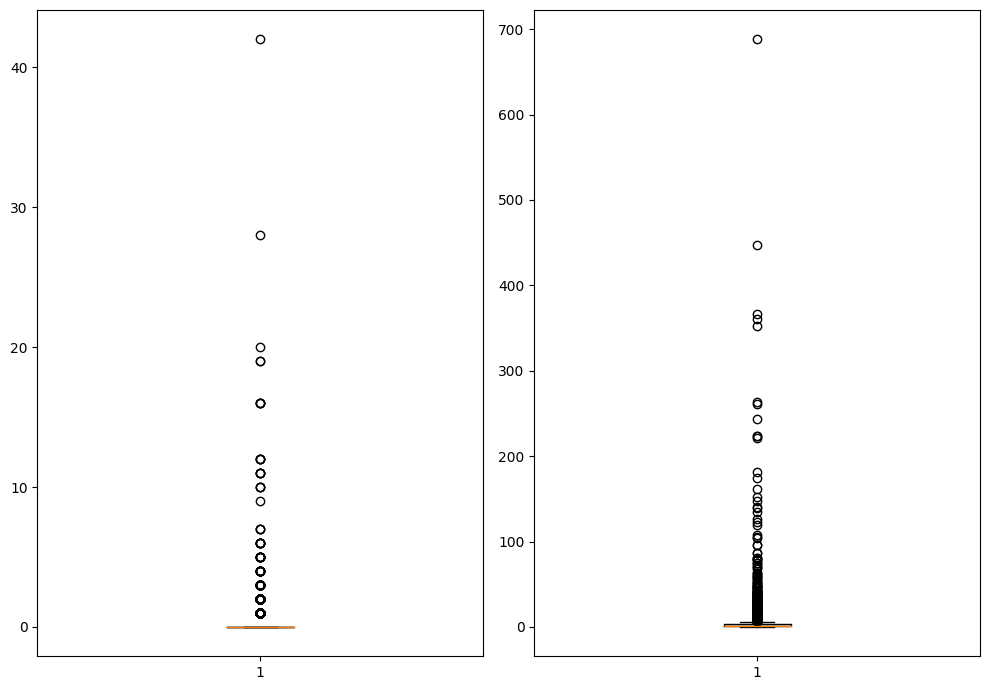

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize =(10, 7), tight_layout = True)
ax1.boxplot(temp_x[0])
ax2.boxplot(temp_x[1])
plt.show()

<AxesSubplot:xlabel='0', ylabel='Count'>

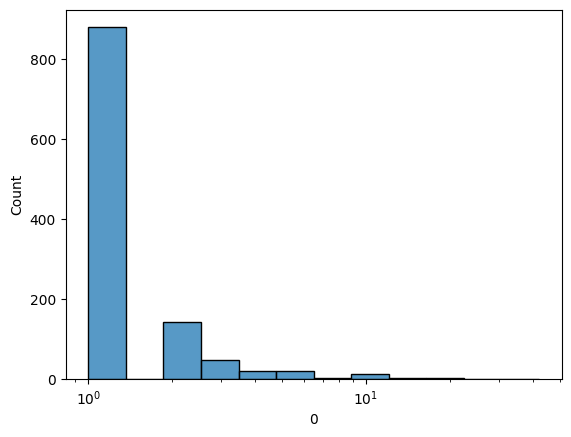

In [45]:
#fig = plt.figure(figsize = (10,5))
#binwidth = 1
#plt.hist(temp_x[0], bins = range(min(temp_x[0]), max(temp_x[0]) + binwidth, binwidth))
#plt.show()
#Data heavily skewed distributions, it’s better to define the bins used log space.
#Since log of 0 is error. Lets filter out records with 0. In our case 0 is no records belong to that class label
sns.histplot(temp_x[temp_x[0]>0][0],  log_scale = True)

<AxesSubplot:xlabel='1', ylabel='Count'>

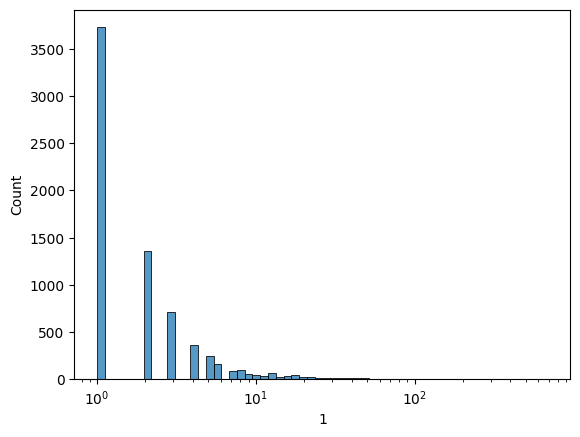

In [46]:
sns.histplot(temp_x[temp_x[1]>0][1],  log_scale = True)

#### Observation: ####

* There are resource where there are no -ve class label. </br>
    Can we say that those RESOURCE are always assign to all employee or we do not have enough sample for those RESOURCE?
    -  Unique number of records for RESOURCE: 7518
    - RESOURCE with no -ve class label: 6384
    - RESOURCE with no +ve class label: 292
    - So approx 11% ( (7518 - ( 6384 + 292)) /7518 ) of RESOURCE have both class data for classification and remaining approx 89% data points have either of one type of class labels.

For futher analysis let add a feature column that will help use to identify if the RESOURCE has all the data point belong to one type of class lable, 50-50 class labels or other.

In [47]:
train['ONLY_SINGLE_EQUAL_DATA_POINTS'] = 0 #np.nan
#Label 1 for Single data points for either of label
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[1]==1) & (temp_x[0]==0)].RESOURCE)].index,'ONLY_SINGLE_EQUAL_DATA_POINTS'] = 1
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[0]==1) & (temp_x[1]==0)].RESOURCE)].index,'ONLY_SINGLE_EQUAL_DATA_POINTS'] = 1

#Label 2 for Equal data points of both label
train.loc[train[train.RESOURCE.isin(temp_x[temp_x[0]== temp_x[1]].RESOURCE)].index,'ONLY_SINGLE_EQUAL_DATA_POINTS'] = 2

#For rest Label 0
#train.ONLY_SINGLE_EQUAL_DATA_POINTS.fillna(0, inplace = True)

#Label if we have only positive class label
train['IS_ONLY_POS_LABEL'] = 0
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[0]==0)].RESOURCE)].index,'IS_ONLY_POS_LABEL'] = 1

#Label if we have only negative class label
train['IS_ONLY_NEG_LABEL'] = 0
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[1]==0)].RESOURCE)].index,'IS_ONLY_NEG_LABEL'] = 1

print('='*20)
print(train.ONLY_SINGLE_EQUAL_DATA_POINTS.value_counts())
print('='*20)
print(train.IS_ONLY_POS_LABEL.value_counts())
print('='*20)
print(train.IS_ONLY_NEG_LABEL.value_counts())
#print('='*20)

0    26173
1     3822
2      396
Name: ONLY_SINGLE_EQUAL_DATA_POINTS, dtype: int64
0    15328
1    15063
Name: IS_ONLY_POS_LABEL, dtype: int64
0    30065
1      326
Name: IS_ONLY_NEG_LABEL, dtype: int64


In [48]:
train.head()

ACTION RESOURCE  MGR_ID ROLE_ROLLUP_1 ROLE_ROLLUP_2 ROLE_DEPTNAME  \
0       1    39353   85475        117961        118300        123472   
1       1    17183    1540        117961        118343        123125   
2       1    36724   14457        118219        118220        117884   
3       1    36135    5396        117961        118343        119993   
4       1    42680    5905        117929        117930        119569   

  ROLE_TITLE ROLE_FAMILY_DESC ROLE_FAMILY ROLE_CODE  \
0     117905           117906      290919    117908   
1     118536           118536      308574    118539   
2     117879           267952       19721    117880   
3     118321           240983      290919    118322   
4     119323           123932       19793    119325   

   ONLY_SINGLE_EQUAL_DATA_POINTS  IS_ONLY_POS_LABEL  IS_ONLY_NEG_LABEL  
0                              0                  1                  0  
1                              0                  0                  0  
2                              0                  1                  0  
3                              1                  1                  0  
4                              0                  1                  0

In [49]:
#Based on our previous analysis there are only 11% "RESOURCE" that have some distrubution between +ve and -ve labels based on there ROLE features
#Will filter them out for futher analysis

#list_resource_with_has_only_one_type_label = np.append(temp_x[temp_x[1] == 0].RESOURCE.values,  #Filter out "RESOURCE" where there are no +ve class label
#                                                       temp_x[temp_x[0] == 0].RESOURCE.values,  #Filter out "RESOURCE" where there are no -ve class label
#                                                       axis = 0
#                                                      )

In [50]:
del [temp_x]
gc.collect()

3332

#### Observation: ####
* 15384 resource data points have only one type of class label. So we do not have enought -ve or +ve class label.
* of 15384 we have 4223 data points that either +ve or -ve class.
In both the case we do not have enought data points to generalize those data point.

***Note:*** On futher thought it make sence that there are RESOURCE with no -ve class label.</br>
**e.g** in case of Software Developer and Support Enginer Role there are some set of RESOURCE that are only require the role the employee. i.e IDE is not need to Support Enginer role like wise is the case of Support Enginer.</br>
So there are many RESOURCE with no -ve class label. -ve class sample make sense only if the resource of particular role need to be segreated. e.g Resource_1 and Resource_2 belong to Suport Engineer Role, but only Resource_1 is assigned to employee with Role1.

### Feature : ROLE_TITLE AND ROLE_CODE ###

In [51]:
col1 = 'ROLE_CODE'
col2 = 'ROLE_TITLE'

pair = len(train.groupby([col1,col2]).size())
single = len(train.groupby([col1]).size())

print(col1, col2, pair, single)

ROLE_CODE ROLE_TITLE 343 343


In [52]:
# Number of unique ROLES feature per RESOURCE. 
# But counting the number of unique value for each feature will give idea the details we get from the role feature for the given resource. 
# i.e various combination of role feature to identify "RESOURCE" and the "ACTION"

temp_out = (train[['ACTION', 'RESOURCE', 
                   'ROLE_TITLE', 'ROLE_CODE']]
             .drop_duplicates()
             .groupby(by = ['RESOURCE'])
             .agg(
                  COUNT_ROLE_TITLE_PER_RESOURCE = ('ROLE_TITLE', 'nunique'),                  
                  COUNT_ROLE_CODE_PER_RESOURCE = ('ROLE_CODE', 'nunique'),
                 )
             .reset_index()
             .sort_values(by = [
                                'COUNT_ROLE_TITLE_PER_RESOURCE',                               
                                'COUNT_ROLE_CODE_PER_RESOURCE'
                               ])
            )

temp_out

RESOURCE  COUNT_ROLE_TITLE_PER_RESOURCE  COUNT_ROLE_CODE_PER_RESOURCE
1      100003                              1                             1
2      100028                              1                             1
3      100031                              1                             1
5      100038                              1                             1
7        1001                              1                             1
...       ...                            ...                           ...
2228    32270                             83                            83
5362    75078                             89                            89
3184     3853                             92                            92
1518    25993                            108                           108
6000    79092                            121                           121

[7518 rows x 3 columns]

In [53]:
#ROLE_TITLE and ROLE_CODE seem to have same number of unique count. Lets check if we can us either one.
temp_out[['RESOURCE','COUNT_ROLE_TITLE_PER_RESOURCE','COUNT_ROLE_CODE_PER_RESOURCE']]

RESOURCE  COUNT_ROLE_TITLE_PER_RESOURCE  COUNT_ROLE_CODE_PER_RESOURCE
1      100003                              1                             1
2      100028                              1                             1
3      100031                              1                             1
5      100038                              1                             1
7        1001                              1                             1
...       ...                            ...                           ...
2228    32270                             83                            83
5362    75078                             89                            89
3184     3853                             92                            92
1518    25993                            108                           108
6000    79092                            121                           121

[7518 rows x 3 columns]

In [54]:
train[train.RESOURCE == 33642].sort_values(by = ['ROLE_TITLE','ROLE_CODE'])

Empty DataFrame
Columns: [ACTION, RESOURCE, MGR_ID, ROLE_ROLLUP_1, ROLE_ROLLUP_2, ROLE_DEPTNAME, ROLE_TITLE, ROLE_FAMILY_DESC, ROLE_FAMILY, ROLE_CODE, ONLY_SINGLE_EQUAL_DATA_POINTS, IS_ONLY_POS_LABEL, IS_ONLY_NEG_LABEL]
Index: []

In [55]:
del [temp_out]
gc.collect()

0

#### Observation: #### 

It seems like these 2 columns have 1:1 relationship. For each unique value in column ROLE_CODE there is 1 and only 1 unique value in column ROLE_TITLE. In other words we don't need both columns to build a model, so I'm removing ROLE_TITLE.

### Are there any similiarity in the ROLE's feature for these RESOURCE ? ###

In [56]:
print('Number of records with same ROLE\'s feature but different RESOURCE\'s')
dup = train.duplicated(subset = ['ACTION','ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'])
dup.value_counts()

Number of records with same ROLE's feature but different RESOURCE's


True     23295
False     7096
dtype: int64

**Note:** </br>
When using 'ACTION' when calculate duplicate</br>
**o/p:**</br>
True     23300</br>
False     7096</br>

When using without 'ACTION' when calculate duplicate</br>
**o/p:**</br>
True     23974</br>
False     6422</br>


In [57]:
train[dup].sort_values(by = ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'])

ACTION RESOURCE  MGR_ID ROLE_ROLLUP_1 ROLE_ROLLUP_2 ROLE_DEPTNAME  \
31869       1    36858   60982         11146        118491        117884   
28300       1    20292   53519         11146        118491        117884   
21106       1    79092   14674         11146        118491        117920   
16031       1    79092   21340         11146        118491        117920   
5344        1    34313   14674         11146        118491        117920   
...       ...      ...     ...           ...           ...           ...   
17323       1    39373   50781         91261        118026        139759   
17804       1   312153   50781         91261        118026        139759   
9364        1    74258   50781         91261        118026        139759   
22853       1    39374   50781         91261        118026        139759   
28769       1    39371   50781         91261        118026        139759   

      ROLE_TITLE ROLE_FAMILY_DESC ROLE_FAMILY ROLE_CODE  \
31869     117879           117886       19721    117880   
28300     117885           117913      117887    117888   
21106     118568           120877       19721    118570   
16031     118568           131694       19721    118570   
5344      118568           163031       19721    118570   
...          ...              ...         ...       ...   
17323     117905           117906      290919    117908   
17804     117905           117906      290919    117908   
9364      118321           117906      290919    118322   
22853     118321           117906      290919    118322   
28769     118321           117906      290919    118322   

       ONLY_SINGLE_EQUAL_DATA_POINTS  IS_ONLY_POS_LABEL  IS_ONLY_NEG_LABEL  
31869                              0                  1                  0  
28300                              0                  0                  0  
21106                              0                  0                  0  
16031                              0                  0                  0  
5344                               0                  1                  0  
...                              ...                ...                ...  
17323                              0                  1                  0  
17804                              0                  1                  0  
9364                               1                  1                  0  
22853                              1                  1                  0  
28769                              0                  1                  0  

[23295 rows x 13 columns]

##### Observation: #####

- We have 23300 where we have same ROLE's feature but different RESOURCE with same ACTION. This proof that multiple RESOURCE that are assign to employee of same ROLE's. </br>
- We can create a new feature by various combine of 'ROLE_ROLLUP_1' + 'ROLE_ROLLUP_2' + 'ROLE_DEPTNAME' + 'ROLE_FAMILY_DESC' + 'ROLE_FAMILY' + 'ROLE_CODE' and encode RESOURCE using the new combined features.</br>
    **Idea:** to group RESOURCE that are related to certain ROLE's. This will act as filter between the RESOURCE required for each ROLE's
    e.g Developer will need access to RESOURCE that are relevent to code development.
        But HR will not need access to those RESOURCES.

### Feature: Relation MGR_ID with Target ###

In [58]:
train.ACTION.value_counts()

1    28551
0     1840
Name: ACTION, dtype: int64

In [59]:
grp_mgr_id = (train.groupby(['ACTION','MGR_ID']).agg(target_mean =  ('ACTION','mean'), 
                                                            target_count = ('ACTION','count')
                                                            )
                                                            .reset_index()
                                                            .sort_values(by = ['MGR_ID','target_mean'], ascending = True))

grp_mgr_id.head()

ACTION  MGR_ID  target_mean  target_count
0         0      25          0.0             6
791       1      25          1.0            21
792       1      27          1.0            16
793       1      30          1.0             8
794       1      32          1.0             3

In [60]:
grp_mgr_id[(grp_mgr_id.target_mean<1.0)]

ACTION  MGR_ID  target_mean  target_count
0         0      25          0.0             6
1         0      33          0.0             1
2         0      36          0.0             1
3         0      46          0.0             1
4         0      47          0.0             1
..      ...     ...          ...           ...
786       0  273476          0.0             2
787       0  274154          0.0             1
788       0  278563          0.0             5
789       0  310646          0.0             1
790       0  310767          0.0             1

[791 rows x 4 columns]

In [61]:
grp_mgr_id[(grp_mgr_id.target_mean<1.0) & (grp_mgr_id.target_mean>0.0)]

Empty DataFrame
Columns: [ACTION, MGR_ID, target_mean, target_count]
Index: []

In [62]:
grp_mgr_id[(grp_mgr_id.target_mean<1.0)].target_count.sum()

1840

#### Observation #### 
* MGR_ID classify all the -ve sample. But if consider this it will not be able create a model that will generalize well.   

### Feature: ROLE_ROLLUP_1 and ROLE_ROLLUP_2 ###

Analysis with both type of "RESOURCE" distrubution(i.e single and more the one sample per RESOURCE)

In [63]:
grp_role_rollup_2 = (train.groupby(['RESOURCE','ROLE_ROLLUP_2']).agg(target_mean =  ('ACTION','mean'), 
                                                                     target_count = ('ACTION','count')
                                                                     )
                                                                     .reset_index()
                                                                     .sort_values(by = ['RESOURCE','target_mean'], ascending = True))
#grp_role_rollup_2
display(grp_role_rollup_2[grp_role_rollup_2.RESOURCE.isin([0,153])])
print('='*50)
display(grp_role_rollup_2[(grp_role_rollup_2.target_mean != 0.0) & (grp_role_rollup_2.target_mean != 1.0)])

Empty DataFrame
Columns: [RESOURCE, ROLE_ROLLUP_2, target_mean, target_count]
Index: []

RESOURCE ROLE_ROLLUP_2  target_mean  target_count
92        1020        118446     0.875000             8
77        1020        118052     0.947368            19
85        1020        118225     0.960000            25
122       1023        118327     0.937500            16
507     116517        117962     0.500000             2
...        ...           ...          ...           ...
13269      969        118257     0.666667             3
13291      971        118300     0.916667            12
13302      972        118343     0.975000            40
13315      974        118343     0.900000            10
13415      998        118300     0.666667             3

[715 rows x 4 columns]

In [64]:
# Number of "RESOURCE" each "ROLE_ROLLUP_2" define them
(train.groupby(["ROLE_ROLLUP_2"]).agg(target_count = ('RESOURCE','count'))
                                 .reset_index()
                                 .sort_values(by = ['target_count'], ascending = False))

ROLE_ROLLUP_2  target_count
61         118300          4238
65         118343          3631
63         118327          2490
55         118225          2381
68         118386          1696
..            ...           ...
129        120355             1
124        120018             1
107        119344             1
91         118907             1
176         32137             1

[177 rows x 2 columns]

#### Observartion: ####

 * Number of sample resource count per roles "ROLE_ROLLUP_1" looks better.
    - "ROLE_ROLLUP_1": 128
    - "ROLE_ROLLUP_2": 177
* Number of records individual feature are not able to clearly classify:
    - "ROLE_ROLLUP_1": 863
    - "ROLE_ROLLUP_2": 720
 * "ROLE_ROLLUP_2" feature alone is able to better clasify number of +ve and -ve sample compare to "ROLE_ROLLUP_1" access of the "RESOURCE".
 * There are "RESOURCE" where "ROLE_ROLLUP_1" is able to clasify better for +ve sample "ROLE_ROLLUP_2" </br>
   e.g </br>
   "ROLL_ROLLUP_1" work better: RESOURCE: 278393, ROLE_ROLLUP_1:118300</br>
   "ROLL_ROLLUP_1" work better: RESOURCE: 278393, ROLE_ROLLUP_1:118300 </br>

In [65]:
te = train[(train.IS_ONLY_POS_LABEL==1) | (train.IS_ONLY_NEG_LABEL==1)].groupby(['ROLE_ROLLUP_1','ROLE_ROLLUP_2']).size().reset_index()
te.columns = ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'size_cnt']
te['single_role_rollup_1'] = te.duplicated(subset = ['ROLE_ROLLUP_1'])

print('Value counts of single_role_rollup_1')
print(te.single_role_rollup_1.value_counts())
print('='*50)
te

Value counts of single_role_rollup_1
False    118
True      54
Name: single_role_rollup_1, dtype: int64


ROLE_ROLLUP_1 ROLE_ROLLUP_2  size_cnt  single_role_rollup_1
0           11146        118491        12                 False
1          117876        117877        81                 False
2          117882        117883         9                 False
3          117887        118178        21                 False
4          117887        119256         3                  True
..            ...           ...       ...                   ...
167        311178        119256         2                 False
168          4292        124335         4                 False
169          4292        126095         7                  True
170          5110        117954       141                 False
171         91261        118026       401                 False

[172 rows x 4 columns]

In [66]:
te[te.single_role_rollup_1]

ROLE_ROLLUP_1 ROLE_ROLLUP_2  size_cnt  single_role_rollup_1
4          117887        119256         3                  True
5          117887        120846         3                  True
6          117887        124157         2                  True
7          117887        176316         1                  True
9          117890        118102        49                  True
12         117902        118041        85                  True
14         117910        118855        10                  True
16         117916        118011        55                  True
17         117916        118150        51                  True
18         117916        119623         6                  True
22         117926        118124        16                  True
23         117926        118266        14                  True
25         117929        117940        47                  True
30         117951        118907         1                  True
33         117961        117969       224                  True
34         117961        118052       747                  True
35         117961        118225      1411                  True
36         117961        118300      2142                  True
37         117961        118327      1396                  True
38         117961        118340         6                  True
39         117961        118343      1708                  True
40         117961        118386       654                  True
41         117961        118413       799                  True
42         117961        118446       589                  True
43         117961        119256        16                  True
44         117961        119715         1                  True
45         117961        121019         3                  True
46         117961        126102         8                  True
49         117978        119216         1                  True
51         117980        118076        20                  True
52         117980        119762         3                  True
56         117993        121602         1                  True
72         118163        119075         1                  True
76         118185         31010         9                  True
80         118212        118580        25                  True
81         118212        119763        14                  True
82         118212        119836         1                  True
83         118212        159716         7                  True
85         118216        118587         8                  True
91         118315        118463        62                  True
98         118555        120862         3                  True
101        118582        120216        10                  True
105        118658        119883         6                  True
106        118658        125100         2                  True
112        118752        119070        64                  True
119        119062        119091       170                  True
120        119062        130600        15                  True
137        120140        140550         1                  True
141        120864        121013        36                  True
144        121005        151110         5                  True
148        122532        123330         8                  True
157        130684        185842         1                  True
160        132839        145248         6                  True
169          4292        126095         7                  True

In [67]:
te = train[(train.IS_ONLY_POS_LABEL==1) | (train.IS_ONLY_NEG_LABEL==1)].groupby(['ROLE_ROLLUP_2', 'ROLE_ROLLUP_1']).size().reset_index()
te.columns = [ 'ROLE_ROLLUP_2', 'ROLE_ROLLUP_1','size_cnt']
te['single_role_rollup_2'] = te.duplicated(subset = ['ROLE_ROLLUP_2'])

print('Value counts of single_role_rollup_2')
print(te.single_role_rollup_2.value_counts())
print('='*50)
te

Value counts of single_role_rollup_2
False    165
True       7
Name: single_role_rollup_2, dtype: int64


ROLE_ROLLUP_2 ROLE_ROLLUP_1  size_cnt  single_role_rollup_2
0          117877        117876        81                 False
1          117883        117882         9                 False
2          117891        117890        56                 False
3          117894        117893        28                 False
4          117903        117902       288                 False
..            ...           ...       ...                   ...
167        176316        117887         1                 False
168        185842        130684         1                 False
169         23779        118074        15                 False
170         31010        118185         9                 False
171         32137        133430         1                 False

[172 rows x 4 columns]

In [68]:
te[te.single_role_rollup_2]

ROLE_ROLLUP_2 ROLE_ROLLUP_1  size_cnt  single_role_rollup_2
47         118164        247952         9                  True
50         118178        118555        40                  True
106        119256        117961        16                  True
107        119256        130570         9                  True
108        119256        183723         2                  True
109        119256        216705         4                  True
110        119256        311178         2                  True

#### Observartion: ####

* Only 54 records where RESOURCE need to be classified by combining ROLE_ROLLUP_1 and ROLE_ROLLUP_2 values.
* Only 7 records where RESOURCE need to be  classified by combining  ROLE_ROLLUP_2 and ROLE_ROLLUP_1 values.
*  Case there is 1:1 relation between ROLE_ROLLUP_2 and ROLE_ROLLUP_1 i.e for every value of ROLE_ROLLUP_1 we have unique value for ROLE_ROLLUP_2. So combining these two column will not help, since this increase the caridinality in the feature column and number of data points is per groupby is less so this will help to generalize the data.
So ROLE_ROLLUP_1 will help to genearlize and ROLE_ROLLUP_2 have unique values that is helpfull at detail classify better.
                                    

In [69]:
grp_role_rollup_2_family_desc = (train.groupby(['RESOURCE','ROLE_ROLLUP_2','ROLE_FAMILY_DESC']).agg(target_mean = ('ACTION','mean'), 
                                                                                                  target_count = ('ACTION','count')
                                                                                                  )
                                                                                                  .reset_index()
                                                                                                  .sort_values(by = ['RESOURCE','target_mean'], ascending = True))

grp_role_rollup_2_family_desc

RESOURCE ROLE_ROLLUP_2 ROLE_FAMILY_DESC  target_mean  target_count
0            0        118386           118785          0.0             1
1            0        118413           117906          1.0             6
2            0        118413           118785          1.0             1
3            0        118413           118842          1.0             1
4            0        118413           123378          1.0             1
...        ...           ...              ...          ...           ...
26043    99954        118343           117906          1.0             1
26044    99954        118343           121556          1.0             1
26045    99954        118343           240983          1.0             1
26046    99989        118316           154441          1.0             1
26047    99989        118316           175154          1.0             2

[26048 rows x 5 columns]

In [70]:
grp_role_rollup_2_family_desc[(grp_role_rollup_2_family_desc.target_mean != 0.0) & (grp_role_rollup_2_family_desc.target_mean != 1.0)]

RESOURCE ROLE_ROLLUP_2 ROLE_FAMILY_DESC  target_mean  target_count
136       1020        118052           118054     0.500000             2
280       1023        118327           117906     0.800000             5
731     116517        117962             4673     0.500000             2
873      13878        118007           122240     0.500000             2
886      13878        118096           117897     0.500000             2
...        ...           ...              ...          ...           ...
25457      917        118300           117906     0.833333             6
25520    91819        118603           118568     0.500000             2
25690      954        118300           117906     0.666667             3
25801      971        118300           157234     0.500000             2
25911      974        118343           117906     0.833333             6

[285 rows x 5 columns]

#### Observation: ####

* Number of records combined feature are not able to clearly classify:
    - "ROLE_ROLLUP_2" + "ROLE_FAMILY_DESC" : 290
* Like "ROLE_ROLLUP_1" we have same relation ship with "ROLE_ROLLUP_2" and "ROLE_FAMILY_DESC"

In [71]:
train.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE', 'ONLY_SINGLE_EQUAL_DATA_POINTS', 'IS_ONLY_POS_LABEL',
       'IS_ONLY_NEG_LABEL'],
      dtype='object')

In [72]:
te = train.groupby(['ROLE_ROLLUP_2','ROLE_DEPTNAME']).agg(target_mean =  ('ACTION','mean'), target_count = ('ACTION','count')).reset_index()
te.sort_values(by = 'target_count', ascending = False)

ROLE_ROLLUP_2 ROLE_DEPTNAME  target_mean  target_count
495         118225        118403     0.974596           433
773         118343        119598     0.981132           424
614         118300        119181     0.960494           405
837         118386        118746     0.913580           324
513         118225        120663     0.949664           298
...            ...           ...          ...           ...
466         118213        122215     1.000000             1
1248        120141        119968     1.000000             1
1249        120141        120142     1.000000             1
459         118213        120126     1.000000             1
1397         32137        118701     1.000000             1

[1398 rows x 4 columns]

#### Observartion: ####
As we add more feature number of samples per resource reduce. We need to generate feature that will be able to generalized better.

In [ ]:
import seaborn as sns

sns.pairplot(train[['ACTION', 'RESOURCE','ROLE_ROLLUP_2','ROLE_FAMILY_DESC','ROLE_CODE',  'ROLE_DEPTNAME']],
             hue = 'ACTION'
            )

Error: Canceled future for execute_request message before replies were done

#### Observartion: ####

- We can see that there is no feature helps clear seperation between the both class.
- Severly imbalance: 94% of +ve sample and 6% of -ve sample 
    - Undersample: balance it we need to throw way approx 90% +ve sample. We are throwing away lot of information about the data and any model trained using such data will be highly bias.
    - Oversampleing: By looking at the result of the scatter plot to perform oversampleie will not make sence as -ve sample are very close to +ve samples.
- Different models approach to try:

    - There is no linear relation ship between the features. So model like Logistic Regression will not be helpfull.

    - K-NN: K-nn is about majority vote in it's proxmity region for the given K. Dominating class has advantage and not much of the the -ve sample are arround the +ve so selecting the K is problem. So result of K-NN will be bias of the +ve class label.

    - Naive Bayes is impaired by imbalance dataset. It impact the prior and likelyhood ratios.


### Check combination of data ###

In [ ]:
target_col = 'ACTION'
col_use = [x for x in train.columns if not x in [target_col, 'ROLE_TITLE', 'MGR_ID']] 
#['ACTION', 'RESOURCE',  "ROLE_ROLLUP_2", 'ROLE_DEPTNAME','ROLE_FAMILY_DESC', 'ROLE_CODE']
col_use

['RESOURCE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [ ]:
train[col_use].nunique()

RESOURCE            7518
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [ ]:
train[col_use] = train[col_use].applymap(str)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30391 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ACTION            30391 non-null  int64 
 1   RESOURCE          30391 non-null  object
 2   MGR_ID            30391 non-null  int64 
 3   ROLE_ROLLUP_1     30391 non-null  object
 4   ROLE_ROLLUP_2     30391 non-null  object
 5   ROLE_DEPTNAME     30391 non-null  object
 6   ROLE_TITLE        30391 non-null  object
 7   ROLE_FAMILY_DESC  30391 non-null  object
 8   ROLE_FAMILY       30391 non-null  object
 9   ROLE_CODE         30391 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB


In [ ]:
#i = 1
#for c1,c2 in permutations(col_use, 2):
#    print(f'{i}: {c1}-{c2}')
#    i += 1
#    print('='*50)

In [ ]:
#col4train = col_use
#col4train.remove('RESOURCE')
new_cols = []
for c1,c2 in permutations(col_use, 2):
    
    name = "{}_{}".format(c1, c2)
    new_cols.append(name)
    train[name] = train[c1] + " " + train[c2]

print(f'Shape: {train.shape}')

train.head()

Shape: (30391, 52)


ACTION RESOURCE  MGR_ID ROLE_ROLLUP_1 ROLE_ROLLUP_2 ROLE_DEPTNAME  \
0       1    39353   85475        117961        118300        123472   
1       1    17183    1540        117961        118343        123125   
2       1    36724   14457        118219        118220        117884   
3       1    36135    5396        117961        118343        119993   
4       1    42680    5905        117929        117930        119569   

  ROLE_TITLE ROLE_FAMILY_DESC ROLE_FAMILY ROLE_CODE  ...  \
0     117905           117906      290919    117908  ...   
1     118536           118536      308574    118539  ...   
2     117879           267952       19721    117880  ...   
3     118321           240983      290919    118322  ...   
4     119323           123932       19793    119325  ...   

  ROLE_FAMILY_ROLE_ROLLUP_2 ROLE_FAMILY_ROLE_DEPTNAME  \
0             290919 118300             290919 123472   
1             308574 118343             308574 123125   
2              19721 118220              19721 117884   
3             290919 118343             290919 119993   
4              19793 117930              19793 119569   

  ROLE_FAMILY_ROLE_FAMILY_DESC ROLE_FAMILY_ROLE_CODE ROLE_CODE_RESOURCE  \
0                290919 117906         290919 117908       117908 39353   
1                308574 118536         308574 118539       118539 17183   
2                 19721 267952          19721 117880       117880 36724   
3                290919 240983         290919 118322       118322 36135   
4                 19793 123932          19793 119325       119325 42680   

  ROLE_CODE_ROLE_ROLLUP_1 ROLE_CODE_ROLE_ROLLUP_2 ROLE_CODE_ROLE_DEPTNAME  \
0           117908 117961           117908 118300           117908 123472   
1           118539 117961           118539 118343           118539 123125   
2           117880 118219           117880 118220           117880 117884   
3           118322 117961           118322 118343           118322 119993   
4           119325 117929           119325 117930           119325 119569   

  ROLE_CODE_ROLE_FAMILY_DESC ROLE_CODE_ROLE_FAMILY  
0              117908 117906         117908 290919  
1              118539 118536         118539 308574  
2              117880 267952          117880 19721  
3              118322 240983         118322 290919  
4              119325 123932          119325 19793  

[5 rows x 52 columns]

In [ ]:
nq = train[new_cols].nunique()
nq[nq.argsort()]

ROLE_ROLLUP_1_ROLE_ROLLUP_2         187
ROLE_ROLLUP_2_ROLE_ROLLUP_1         187
ROLE_CODE_ROLE_FAMILY               343
ROLE_FAMILY_ROLE_CODE               343
ROLE_FAMILY_ROLE_ROLLUP_1           750
ROLE_ROLLUP_1_ROLE_FAMILY           750
ROLE_FAMILY_ROLE_ROLLUP_2          1045
ROLE_ROLLUP_2_ROLE_FAMILY          1045
ROLE_DEPTNAME_ROLE_ROLLUP_1        1185
ROLE_ROLLUP_1_ROLE_DEPTNAME        1185
ROLE_ROLLUP_2_ROLE_DEPTNAME        1398
ROLE_DEPTNAME_ROLE_ROLLUP_2        1398
ROLE_ROLLUP_1_ROLE_CODE            1506
ROLE_CODE_ROLE_ROLLUP_1            1506
ROLE_FAMILY_ROLE_DEPTNAME          1613
ROLE_DEPTNAME_ROLE_FAMILY          1613
ROLE_CODE_ROLE_ROLLUP_2            2125
ROLE_ROLLUP_2_ROLE_CODE            2125
ROLE_FAMILY_ROLE_FAMILY_DESC       2586
ROLE_FAMILY_DESC_ROLE_FAMILY       2586
ROLE_CODE_ROLE_DEPTNAME            2946
ROLE_DEPTNAME_ROLE_CODE            2946
ROLE_CODE_ROLE_FAMILY_DESC         3013
ROLE_FAMILY_DESC_ROLE_CODE         3013
ROLE_FAMILY_DESC_ROLE_ROLLUP_1     3282


In [ ]:

train.groupby('ROLE_ROLLUP_2_ROLE_ROLLUP_1').ACTION.mean()

ROLE_ROLLUP_2_ROLE_ROLLUP_1
117877 117876    0.977778
117883 117882    0.900000
117891 117890    0.973684
117894 117893    0.910714
117903 117902    0.978947
                   ...   
185842 130684    1.000000
23779 118074     1.000000
286791 117961    0.000000
31010 118185     0.825000
32137 133430     1.000000
Name: ACTION, Length: 187, dtype: float64

In [ ]:
train.groupby('ROLE_ROLLUP_1_ROLE_ROLLUP_2').ACTION.mean()

ROLE_ROLLUP_1_ROLE_ROLLUP_2
11146 118491     0.931034
117876 117877    0.977778
117882 117883    0.900000
117882 123999    1.000000
117887 118178    0.942029
                   ...   
311178 119256    1.000000
4292 124335      1.000000
4292 126095      1.000000
5110 117954      0.982143
91261 118026     0.963127
Name: ACTION, Length: 187, dtype: float64

In [ ]:
train.groupby(['ROLE_ROLLUP_1_ROLE_ROLLUP_2'])['ROLE_FAMILY_ROLE_CODE'].agg(lambda x: " ".join(list([str(y) for y in x])))

ROLE_ROLLUP_1_ROLE_ROLLUP_2
11146 118491     19721 118570 117887 117888 117887 117973 19721...
117876 117877    19721 117880 19721 118570 19721 247660 19793 1...
117882 117883    19721 117880 117887 117888 19721 117880 117887...
117882 123999    117887 118055 117887 118055 117887 118055 1178...
117887 118178    118638 119851 292795 118943 292795 118943 1219...
                                       ...                        
311178 119256                          118474 136061 118474 136061
4292 124335      119772 130062 119184 128095 119184 128095 1191...
4292 126095      117887 117973 117887 117973 119184 119194 1191...
5110 117954      19721 118570 19721 118570 118870 124539 19721 ...
91261 118026     118205 119964 290919 118322 290919 118279 2909...
Name: ROLE_FAMILY_ROLE_CODE, Length: 187, dtype: object

In [ ]:
train.groupby(['ROLE_ROLLUP_1'])['ROLE_DEPTNAME'].agg(lambda x: " ".join(list([str(y) for y in x])))

ROLE_ROLLUP_1
11146     117941 117884 118599 117920 117884 117920 1179...
117876    117878 117878 117878 118810 117878 118810 1188...
117882    117884 117884 117884 117884 118552 118552 1178...
117887    118575 117945 117945 119796 135245 117945 1183...
117890    117878 117878 117878 117878 117878 117878 1178...
                                ...                        
247952    117878 117878 117878 117878 117878 117878 1178...
311178                                        118471 118471
4292      274241 118378 118378 118378 118378 118378 1183...
5110      117895 117895 122672 117895 122672 117895 1226...
91261     118202 119507 118202 118202 119362 119507 1182...
Name: ROLE_DEPTNAME, Length: 128, dtype: object

Observation:
* Combination of columns like  "ROLE_ROLLUP_1" and "ROLE_ROLLUP_2" or "ROLE_ROLLUP_2" AND "ROLE_ROLLUP_1" is same. so we should not be conside those as Target Encode for them will be same.
* Combination of some feature have high cardinality. 
    - Combining such catagories together reduces the number of observation per group value in the resulting features encoding. e.g Number of unique values for "ROLE_FAMILY_DESC_RESOURCE" = 22734 which is equal to total size of the training dataset.
    - It will not generalize well and the model will overfit.
* KFoldTargetEncoding: Will not work in case of "RESOURCE"  as 89% of records has only 1 data points. In this case most of the time in each fold the value will be NaN and if we replace NaN to global mean of "ACTION" we will be encoding most of the value with global mean which is no different the standard target encoding which will not be helpful. Approx 85% of "RESOURCE" will have the same probality/mean "ACTION"value. KFoldTE is helpfull for less cardinal feature or if in each fold will have most of group value in the valid dataset. Since Fold are random it not possible. 
    - Solution:
        - Instead of KFold we can use StrafiedKFold so that it ensure that in each Kold we have same proportion of +ve ad -ve sample. 
        - Instead of replacing the NaN with the Global mean, will compute the mean of target("ACTION") in the Fold train dataset(X_tr) of the KFold split and replace the missing NaN in validation dataset(X_val) of the KFold split with that mean.
* Frequency/Count Encoding: This might be helpfull for those feature that occure least in the dataset for some particular "RESOURCE".
* When groupby column and join value of the other feature for that group we see repeation of the feature values. 
    If we think, values of feature's are set of word (Corpus) and when we join based on all the possible values for a group we get a string that can be thought of a document.  

In [ ]:
targetcol = 'ACTION'
col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
train = train[col_use]
col_use

['ACTION',
 'RESOURCE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

# Feature Engineering #

#### Combine feature ####

In [5]:
targetcol = 'ACTION'
col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
train = train[col_use]
col_use

['ACTION',
 'RESOURCE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [6]:
def combine_cols( dataset, columns):

    for c1,c2 in combinations(columns, 2): #permutations #Number of unique count where same i.e col1_col2 == col2_col1
    
        if (c1 == targetcol) | (c2 == targetcol):
            continue

        name = "{}_{}".format(c1, c2)

        dataset[name] = dataset[c1] + " " + dataset[c2]

    return dataset

train = combine_cols(train, col_use)

In [24]:
train.columns

Index(['ACTION', 'RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
       'RESOURCE_ROLE_ROLLUP_1', 'RESOURCE_ROLE_ROLLUP_2',
       'RESOURCE_ROLE_DEPTNAME', 'RESOURCE_ROLE_FAMILY_DESC',
       'RESOURCE_ROLE_FAMILY', 'RESOURCE_ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE'],
      dtype='object')

In [ ]:
#c1 = 'ROLE_FAMILY'
#c2 = 'ROLE_CODE'
#name = "{}_{}".format(c1, c2)
#train[name] = train[c1] + " " + train[c2]

In [ ]:
nq = train.nunique() #train[new_cols].nunique()
nq = nq[nq.argsort()]
nq = pd.DataFrame(nq.reset_index())
nq.columns = ['group_by_feature', 'num_unique']
nq

group_by_feature  num_unique
0                           ACTION           2
1                      ROLE_FAMILY          67
2                    ROLE_ROLLUP_1         128
3                    ROLE_ROLLUP_2         177
4      ROLE_ROLLUP_1_ROLE_ROLLUP_2         187
5            ROLE_FAMILY_ROLE_CODE         343
6                        ROLE_CODE         343
7                    ROLE_DEPTNAME         449
8        ROLE_ROLLUP_1_ROLE_FAMILY         750
9        ROLE_ROLLUP_2_ROLE_FAMILY        1045
10     ROLE_ROLLUP_1_ROLE_DEPTNAME        1185
11     ROLE_ROLLUP_2_ROLE_DEPTNAME        1398
12         ROLE_ROLLUP_1_ROLE_CODE        1506
13       ROLE_DEPTNAME_ROLE_FAMILY        1613
14         ROLE_ROLLUP_2_ROLE_CODE        2125
15                ROLE_FAMILY_DESC        2358
16    ROLE_FAMILY_DESC_ROLE_FAMILY        2586
17         ROLE_DEPTNAME_ROLE_CODE        2946
18      ROLE_FAMILY_DESC_ROLE_CODE        3013
19  ROLE_ROLLUP_1_ROLE_FAMILY_DESC        3282
20  ROLE_ROLLUP_2_ROLE_FAMILY_DESC        3949
21  ROLE_DEPTNAME_ROLE_FAMILY_DESC        4553
22                        RESOURCE        7518
23          RESOURCE_ROLE_ROLLUP_1       11091
24            RESOURCE_ROLE_FAMILY       13195
25          RESOURCE_ROLE_ROLLUP_2       13422
26          RESOURCE_ROLE_DEPTNAME       17354
27              RESOURCE_ROLE_CODE       19043
28       RESOURCE_ROLE_FAMILY_DESC       22734

In [ ]:
train[['ROLE_FAMILY_ROLE_CODE', 'ROLE_CODE']].head(5)

ROLE_FAMILY_ROLE_CODE ROLE_CODE
0         290919 117908    117908
1         308574 118539    118539
2          19721 117880    117880
3         290919 118322    118322
4          19793 119325    119325

In [ ]:
train[['ROLE_FAMILY', 'ROLE_CODE']].groupby('ROLE_CODE')['ROLE_FAMILY'].count()

ROLE_CODE
117880     930
117888     539
117898     110
117900     212
117908    3194
          ... 
254396       3
258436       7
266863       1
268610       1
270691       1
Name: ROLE_FAMILY, Length: 343, dtype: int64

In [ ]:
train[['ROLE_FAMILY', 'ROLE_CODE']].groupby('ROLE_FAMILY')['ROLE_CODE'].count()

ROLE_FAMILY
117887    2047
118131     156
118205     435
118295     485
118331     881
          ... 
292795    1076
308574    1274
3130       144
4673       382
6725        89
Name: ROLE_CODE, Length: 67, dtype: int64

**Observation**

 * We have similar unique count when combining ROLE_CODE with ROLE_FAMILY_ROLE_CODE. Which means combination of these two feature give unique output
        ROLE_CODE = ROLE_FAMILY_ROLE_CODE = 343
   But permutation of the these column yield different result. 
 * Feature combined with RESOURCE has large nunique. Which makes sense since nunique from RESOURCE is verg large.

   

#### Target Encoding ####

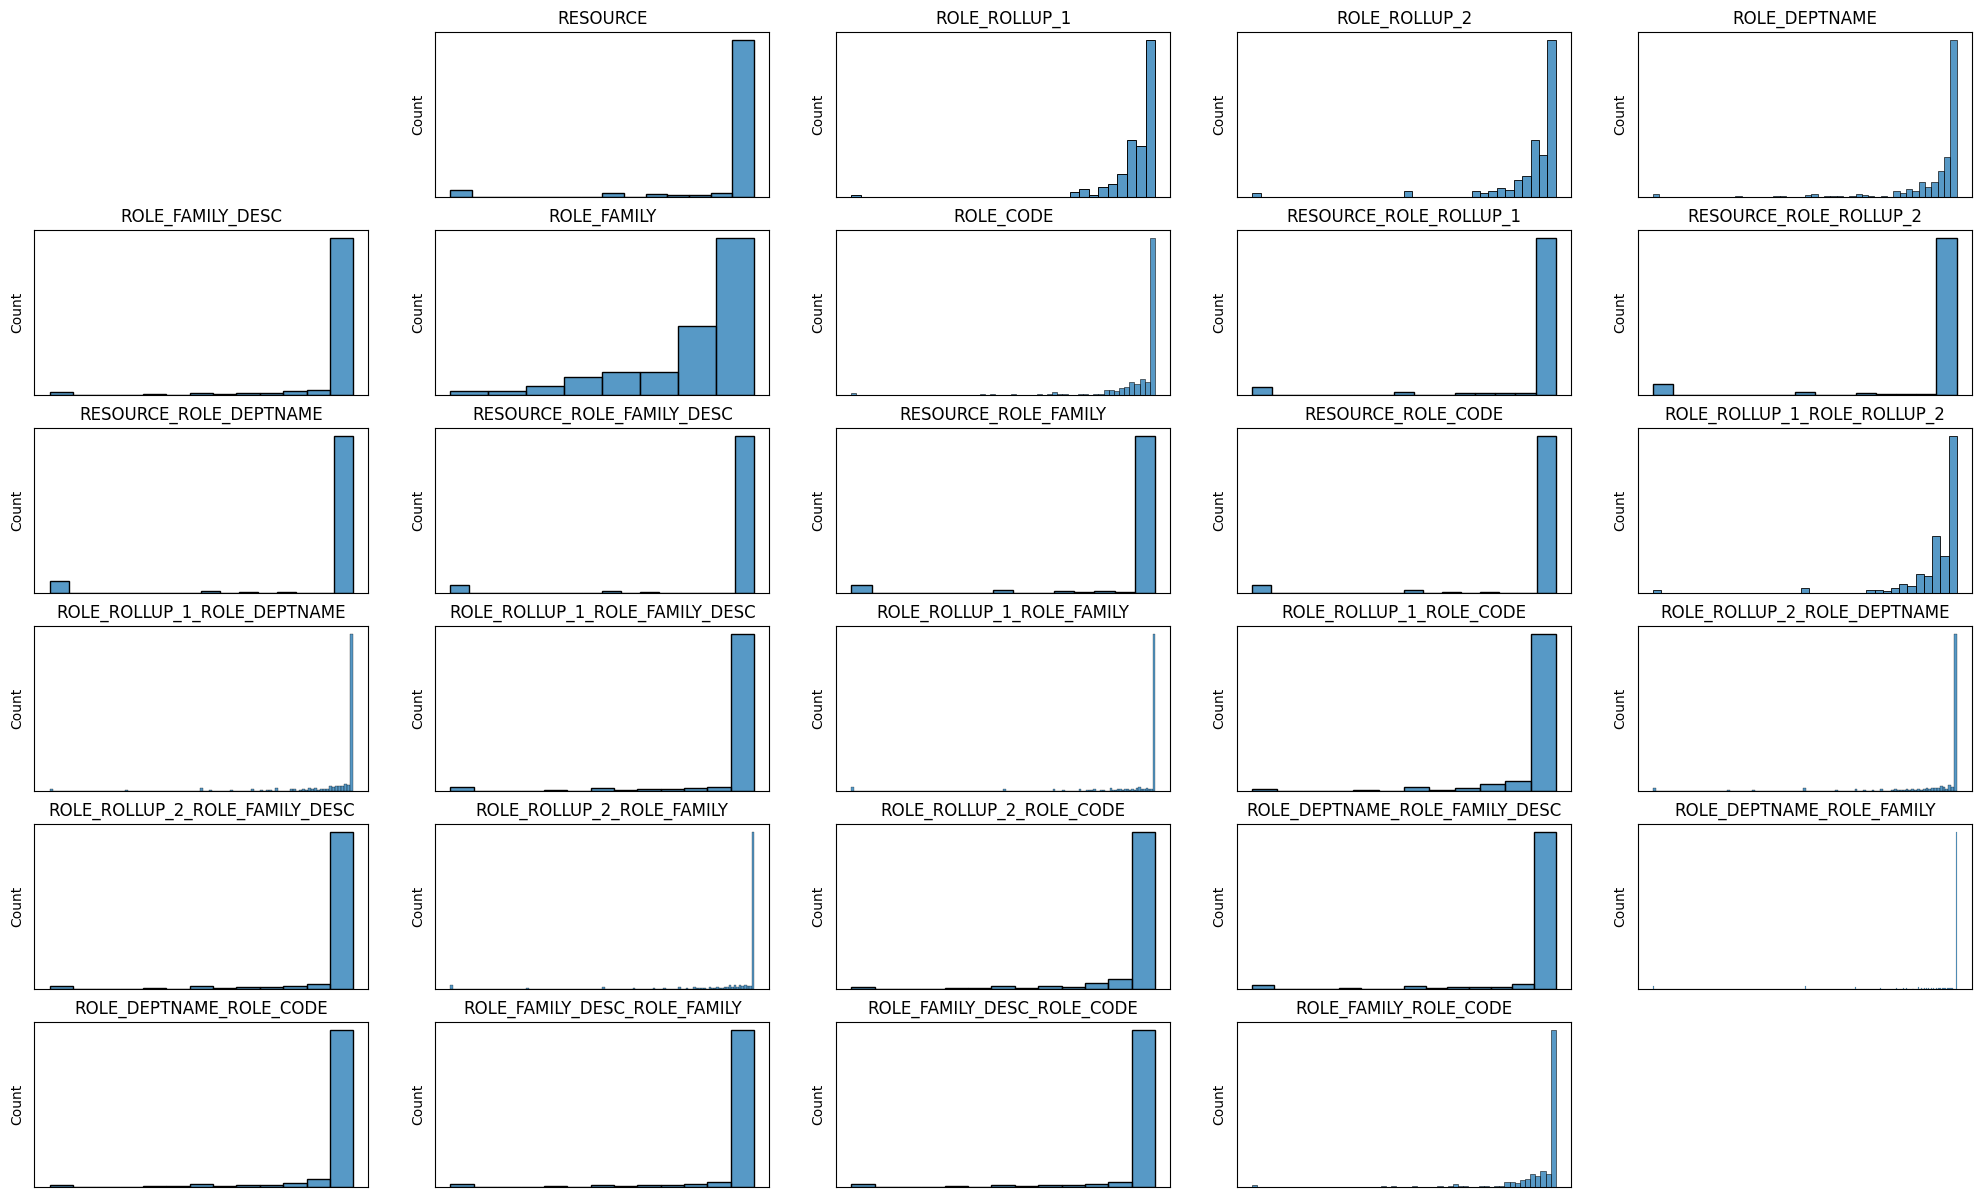

In [ ]:
fig = plt.figure(figsize=(25,15))

for i in range(0, train.shape[1]):
    
    if train.columns[i] != 'ACTION':

        #sns.displot(train.groupby('ROLE_FAMILY_ROLE_CODE').ACTION.mean())
        axes = sns.histplot(train.groupby(train[train.columns[i]]).ACTION.mean(), ax = plt.subplot(6, 5, i+1))
        axes.set_title(train.columns[i])
        
        axes.set_xlabel("")
        axes.xaxis.set_major_locator(ticker.NullLocator())
        axes.yaxis.set_major_locator(ticker.NullLocator())

plt.show()

**Observation**
* Combination of RESOURCE does not help much. Since we have many unique RESOURCE mean target result in 1. So combination of feature output same result.
* TargetEncoding of features will not help as 90% of feature values for most of the feature have target mean as 1. 

In [ ]:
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder

kfold_TE_obj = KFoldTargetEncoder(concat_result_X = False)
transform_kfold_TE = kfold_TE_obj.fit_transform(train)
transform_kfold_TE.head()

RESOURCE_Kfold_TE  ROLE_ROLLUP_1_Kfold_TE  ROLE_ROLLUP_2_Kfold_TE  \
0           0.939503                0.939503                0.939503   
1           0.939432                0.939432                0.939432   
2           0.939503                0.939503                0.939503   
3           0.939432                0.939432                0.939432   
4           0.939256                0.939256                0.939256   

   ROLE_DEPTNAME_Kfold_TE  ROLE_FAMILY_DESC_Kfold_TE  ROLE_FAMILY_Kfold_TE  \
0                0.939503                   0.939503              0.939503   
1                0.939432                   0.939432              0.939432   
2                0.939503                   0.939503              0.939503   
3                0.939432                   0.939432              0.939432   
4                0.939256                   0.939256              0.939256   

   ROLE_CODE_Kfold_TE  ROLE_ROLLUP_1_ROLE_ROLLUP_2_Kfold_TE  \
0            0.939503                              0.939503   
1            0.939432                              0.939432   
2            0.939503                              0.939503   
3            0.939432                              0.939432   
4            0.939256                              0.939256   

   ROLE_ROLLUP_1_ROLE_DEPTNAME_Kfold_TE  \
0                              0.939503   
1                              0.939432   
2                              0.939503   
3                              0.939432   
4                              0.939256   

   ROLE_ROLLUP_1_ROLE_FAMILY_DESC_Kfold_TE  ...  \
0                                 0.939503  ...   
1                                 0.939432  ...   
2                                 0.939503  ...   
3                                 0.939432  ...   
4                                 0.939256  ...   

   ROLE_ROLLUP_2_ROLE_DEPTNAME_Kfold_TE  \
0                              0.939503   
1                              0.939432   
2                              0.939503   
3                              0.939432   
4                              0.939256   

   ROLE_ROLLUP_2_ROLE_FAMILY_DESC_Kfold_TE  \
0                                 0.939503   
1                                 0.939432   
2                                 0.939503   
3                                 0.939432   
4                                 0.939256   

   ROLE_ROLLUP_2_ROLE_FAMILY_Kfold_TE  ROLE_ROLLUP_2_ROLE_CODE_Kfold_TE  \
0                            0.939503                          0.939503   
1                            0.939432                          0.939432   
2                            0.939503                          0.939503   
3                            0.939432                          0.939432   
4                            0.939256                          0.939256   

   ROLE_DEPTNAME_ROLE_FAMILY_DESC_Kfold_TE  \
0                                 0.939503   
1                                 0.939432   
2                                 0.939503   
3                                 0.939432   
4                                 0.939256   

   ROLE_DEPTNAME_ROLE_FAMILY_Kfold_TE  ROLE_DEPTNAME_ROLE_CODE_Kfold_TE  \
0                            0.939503                          0.939503   
1                            0.939432                          0.939432   
2                            0.939503                          0.939503   
3                            0.939432                          0.939432   
4                            0.939256                          0.939256   

   ROLE_FAMILY_DESC_ROLE_FAMILY_Kfold_TE  ROLE_FAMILY_DESC_ROLE_CODE_Kfold_TE  \
0                               0.939503                             0.939503   
1                               0.939432                             0.939432   
2                               0.939503                             0.939503   
3                               0.939432                             0.939432   
4                               0.93

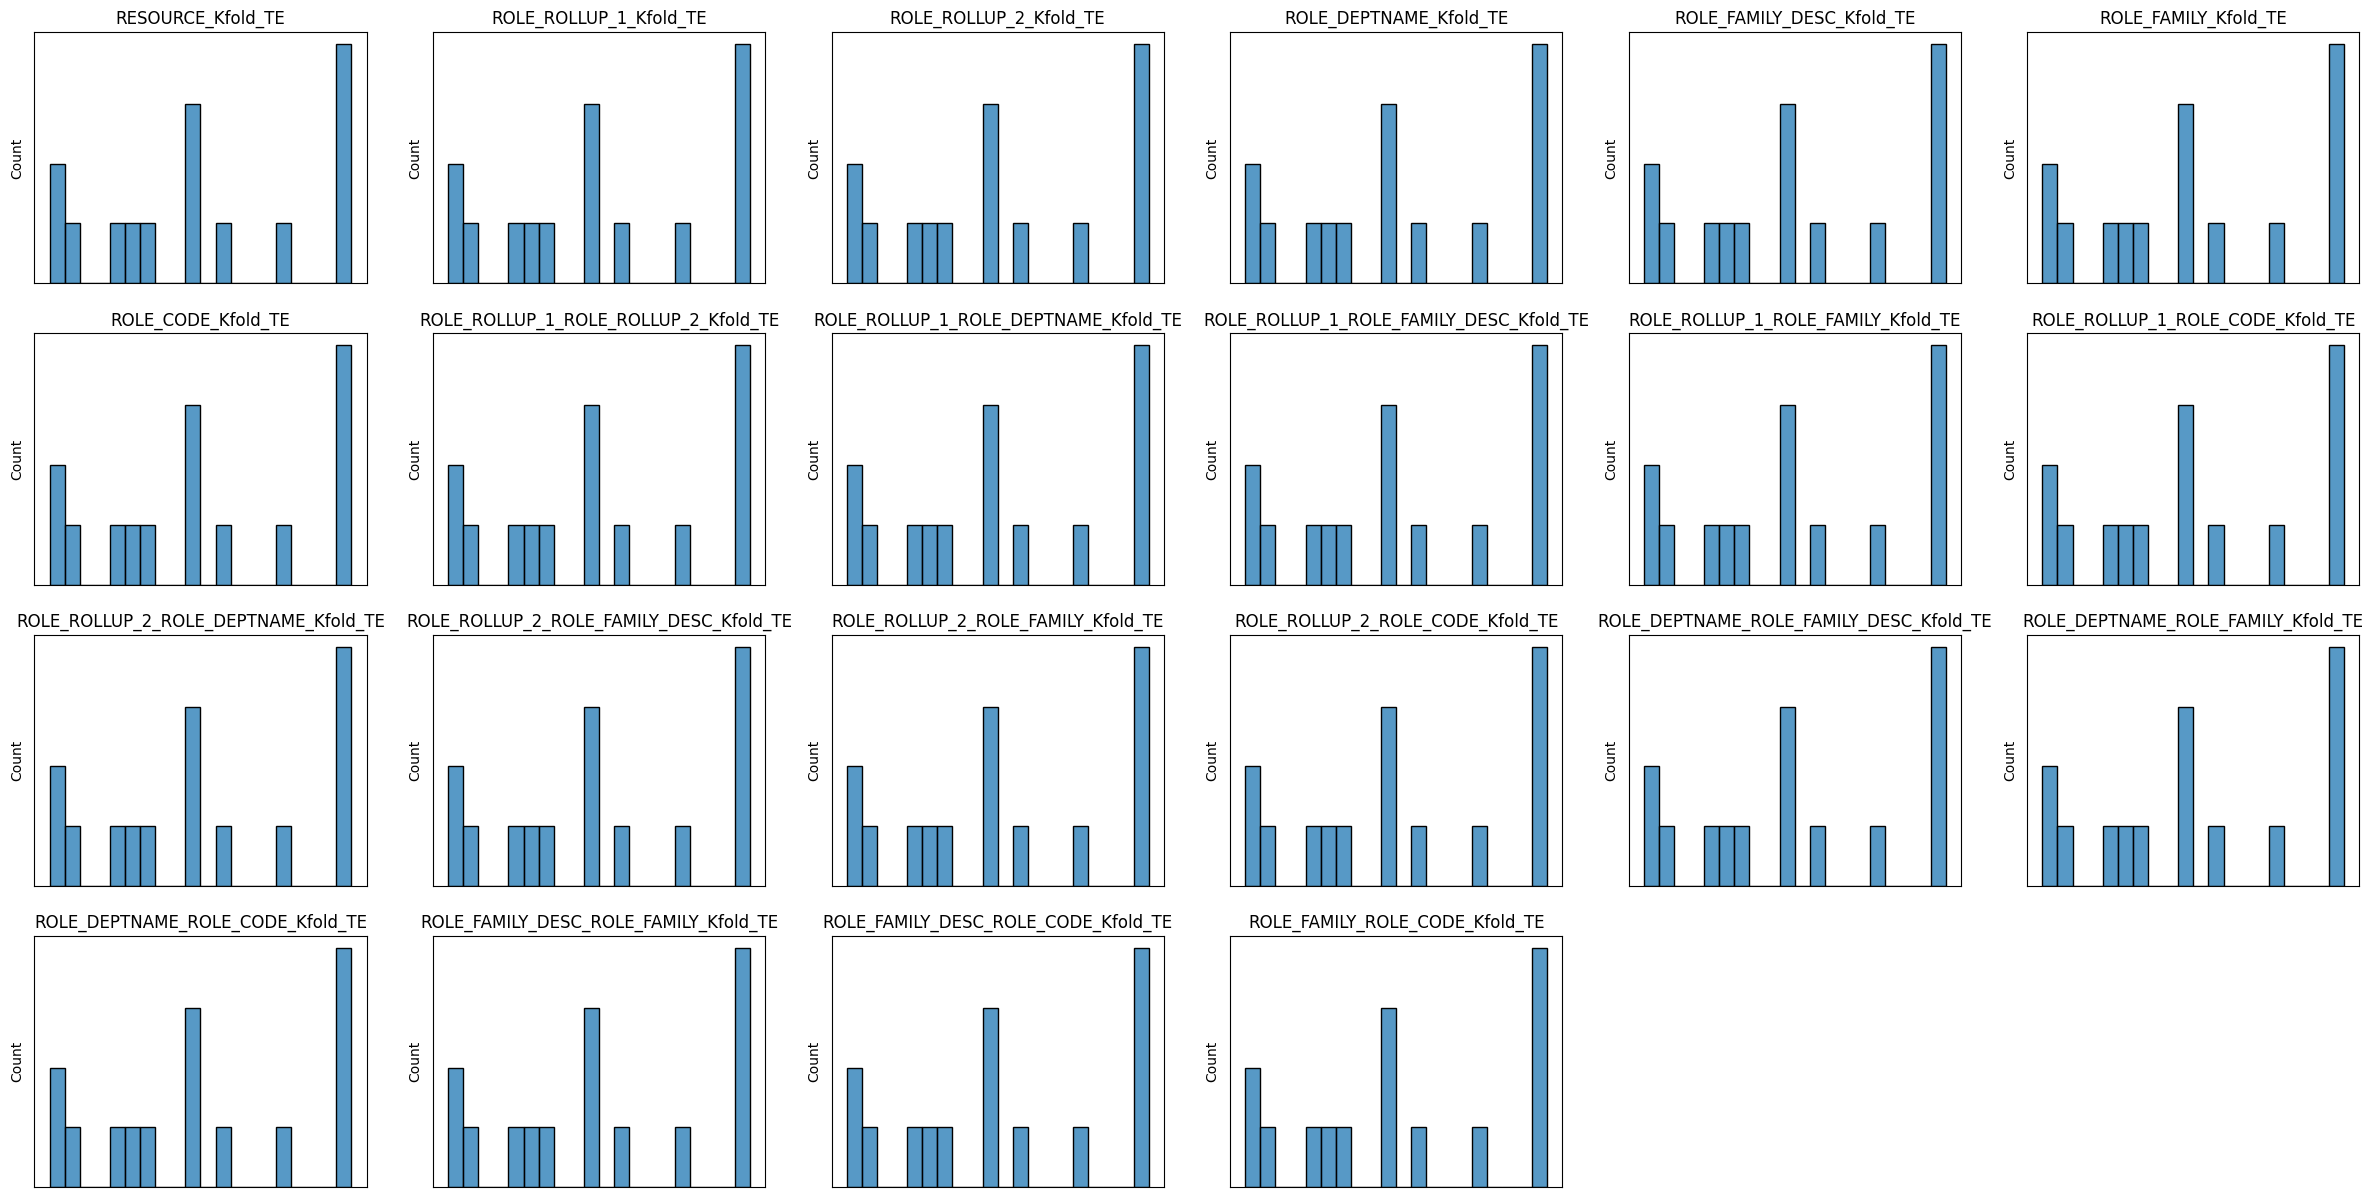

In [ ]:
fig = plt.figure(figsize=(30,15))

for i in range(0, transform_kfold_TE.shape[1]):

        axes = sns.histplot(transform_kfold_TE[transform_kfold_TE.columns[i]], ax = plt.subplot(4, 6, i+1))
        axes.set_title(transform_kfold_TE.columns[i])

        axes.set_xlabel("")
        axes.xaxis.set_major_locator(ticker.NullLocator())
        axes.yaxis.set_major_locator(ticker.NullLocator())

plt.show()

**Observation**

* KFoldTargetEncode result same out for all the columns. 

So either TargetEncode and KFoldTargetEncode will help to classify the class label.

In [ ]:
#Lets drop columns with combination RESOURCE as this increase cardinatlity.
train.drop(['RESOURCE_ROLE_ROLLUP_1', 'RESOURCE_ROLE_FAMILY', 'RESOURCE_ROLE_ROLLUP_2', 'RESOURCE_ROLE_DEPTNAME', 'RESOURCE_ROLE_CODE', 'RESOURCE_ROLE_FAMILY_DESC'], axis = 1, inplace=True)

train.columns

Index(['ACTION', 'RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE'],
      dtype='object')

#### Frequency Encoding ####
Plot distribution of there frequency encoding 

In [ ]:
from src.models.feature_eng.FreqEncoding import FrequencyEncoding

freq_obj = FrequencyEncoding(concat_result_X =  False)
transform_feq = freq_obj.fit_transform(train)

#freq_enc_ROLE_ROLLUP_1 = (train.groupby('ROLE_ROLLUP_1').size()) / len(train)
pd.concat([transform_feq.head(),transform_feq.sample(n=5),transform_feq.tail()], axis = 0)

RESOURCE_FreqEnc  ROLE_ROLLUP_1_FreqEnc  ROLE_ROLLUP_2_FreqEnc  \
0                     3                  20220                   4238   
1                    28                  20220                   3631   
2                     2                    169                    169   
3                  3822                  20220                   3631   
4                     8                    219                    108   
14806                 9                  20220                   2381   
13869                 4                  20220                    933   
29946                82                  20220                   1696   
10486               380                  20220                   4238   
21923                 2                     82                     82   
32764                50                  20220                   4238   
32765                 2                    678                    678   
32766               146                  20220                   2490   
32767                 7                    214                    198   
32768               107                    262                     84   

       ROLE_DEPTNAME_FreqEnc  ROLE_FAMILY_DESC_FreqEnc  ROLE_FAMILY_FreqEnc  \
0                         70                      6133                10078   
1                        155                        12                 1274   
2                        397                        33                 2210   
3                        186                      1172                10078   
4                         44                        18                  358   
14806                    459                      6133                10078   
13869                    545                        90                10078   
29946                    126                        15                  485   
10486                    164                       113                 2047   
21923                      5                         4                 2210   
32764                    186                      1172                10078   
32765                     54                         5                  220   
32766                     41                         2                   77   
32767                    549                       176                 1076   
32768                    586                        28                 2210   

       ROLE_CODE_FreqEnc  RESOURCE_ROLE_ROLLUP_1_FreqEnc  \
0                   3194                               3   
1                     81                              24   
2                    930                               2   
3                   4201                            6634   
4                     74                               3   
14806               4201                               6   
13869               4201                               4   
29946                 34                              48   
10486                380                             262   
21923                971                            6634   
32764               4201                              29   
32765                 24                            6634   
32766                  3                             124   
32767                318                            6634   
32768                971                               9   

       RESOURCE_ROLE_ROLLUP_2_FreqEnc  RESOURCE_ROLE_DEPTNAME_FreqEnc  ...  \
0                                   3                           11827  ...   
1                                   9                           11827  ...   
2                                   2                               2  ...   
3                                8537                           11827  ...   
4                                   2                               2  ...   
14806                               6                               4  ...   
13869                            8537                             

In [ ]:
transform_feq_enc_scale = transform_feq/transform_feq.shape[0]

#transform_feq_enc_scale.head()
pd.concat([transform_feq_enc_scale.head(),transform_feq_enc_scale.sample(n=5),transform_feq_enc_scale.tail()], axis = 0)

RESOURCE_FreqEnc  ROLE_ROLLUP_1_FreqEnc  ROLE_ROLLUP_2_FreqEnc  \
0              0.000099               0.665329               0.139449   
1              0.000921               0.665329               0.119476   
2              0.000066               0.005561               0.005561   
3              0.125761               0.665329               0.119476   
4              0.000263               0.007206               0.003554   
31003          0.000099               0.665329               0.139449   
31348          0.000296               0.665329               0.081932   
24115          0.001316               0.004310               0.003488   
26729          0.000066               0.665329               0.078346   
17097          0.000230               0.665329               0.049916   
32764          0.001645               0.665329               0.139449   
32765          0.000066               0.022309               0.022309   
32766          0.004804               0.665329               0.081932   
32767          0.000230               0.007042               0.006515   
32768          0.003521               0.008621               0.002764   

       ROLE_DEPTNAME_FreqEnc  ROLE_FAMILY_DESC_FreqEnc  ROLE_FAMILY_FreqEnc  \
0                   0.002303                  0.201803             0.331611   
1                   0.005100                  0.000395             0.041920   
2                   0.013063                  0.001086             0.072719   
3                   0.006120                  0.038564             0.331611   
4                   0.001448                  0.000592             0.011780   
31003               0.001185                  0.201803             0.331611   
31348               0.003455                  0.000099             0.004936   
24115               0.002139                  0.000823             0.009608   
26729               0.015103                  0.038564             0.331611   
17097               0.009476                  0.002961             0.331611   
32764               0.006120                  0.038564             0.331611   
32765               0.001777                  0.000165             0.007239   
32766               0.001349                  0.000066             0.002534   
32767               0.018065                  0.005791             0.035405   
32768               0.019282                  0.000921             0.072719   

       ROLE_CODE_FreqEnc  ROLE_ROLLUP_1_ROLE_ROLLUP_2_FreqEnc  \
0               0.105097                             0.139449   
1               0.002665                             0.119476   
2               0.030601                             0.005561   
3               0.138232                             0.119476   
4               0.002435                             0.003554   
31003           0.105097                             0.139449   
31348           0.000987                             0.081932   
24115           0.006416                             0.003488   
26729           0.138232                             0.078346   
17097           0.138232                             0.049916   
32764           0.138232                             0.139449   
32765           0.000790                             0.022309   
32766           0.000099                             0.081932   
32767           0.010464                             0.006515   
32768           0.031950                             0.002764   

       ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc  \
0                                 0.002106   
1                                 0.003981   
2                                 0.000428   
3                                 0.005725   
4                                 0.000724   
31003                             0.001086   
31348                             0.003455   
24115                             0.000132   
26729                             0.014248   
17097                             0.009246   
32764                     

In [ ]:
#Check if KFold Frequency Encoding
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding

kfreq_obj = KFoldFrequencyEncoding(concat_result_X =  False)
transform_kfeq = kfreq_obj.fit_transform(train)

pd.concat([transform_kfeq.head(), transform_kfeq.sample(n=5), transform_kfeq.tail()], axis = 0)

RESOURCE_KfoldFreqEnc  ROLE_ROLLUP_1_KfoldFreqEnc  \
0                          2                       16147   
1                         23                       16200   
2                       3537                         127   
3                          1                       16200   
4                          7                         164   
15786                     16                         536   
24838                     25                       16157   
23627                     11                       16186   
11904                     65                       16157   
10206                      3                       16157   
32764                     37                       16157   
32765                   3637                         536   
32766                    113                       16186   
32767                      6                         168   
32768                     89                         207   

       ROLE_ROLLUP_2_KfoldFreqEnc  ROLE_DEPTNAME_KfoldFreqEnc  \
0                            3362                          55   
1                            2909                         132   
2                             127                         313   
3                            2909                         160   
4                              82                          30   
15786                         536                         317   
24838                        1898                          26   
23627                        3402                         359   
11904                        1973                         116   
10206                        3409                          66   
32764                        3409                         144   
32765                         536                          44   
32766                        1963                          32   
32767                         153                         432   
32768                          65                         462   

       ROLE_FAMILY_DESC_KfoldFreqEnc  ROLE_FAMILY_KfoldFreqEnc  \
0                               4893                      8051   
1                                 10                      1020   
2                                 27                      1779   
3                                955                      8099   
4                                 12                       279   
15786                             71                       720   
24838                              2                       310   
23627                             11                      8035   
11904                             11                       975   
10206                            942                      8086   
32764                            942                      8086   
32765                              4                       170   
32766                            651                        61   
32767                            136                       851   
32768                             21                      1776   

       ROLE_CODE_KfoldFreqEnc  ROLE_ROLLUP_1_ROLE_ROLLUP_2_KfoldFreqEnc  \
0                        2555                                      3362   
1                          70                                      2909   
2                         733                                       127   
3                        3373                                      2909   
4                          52                                        82   
15786                     407                                       536   
24838                     167                                      1898   
23627                    1358                                      3402   
11904                     253                                      1973   
10206                    2569                                      3409   
32764                    3371                                      3409   
32765                      17                   

In [ ]:
transform_kfeq_scale = transform_kfeq/transform_kfeq.shape[0]
pd.concat([transform_kfeq_scale.head(),transform_kfeq_scale.sample(n=5),transform_kfeq_scale.tail()], axis = 0)

RESOURCE_KfoldFreqEnc  ROLE_ROLLUP_1_KfoldFreqEnc  \
0                   0.000066                    0.531309   
1                   0.000757                    0.533053   
2                   0.116383                    0.004179   
3                   0.000033                    0.533053   
4                   0.000230                    0.005396   
26676               0.118127                    0.532592   
14407               0.000066                    0.533053   
20281               0.000066                    0.531309   
5844                0.000099                    0.005396   
11886               0.000033                    0.531309   
32764               0.001217                    0.531638   
32765               0.119674                    0.017637   
32766               0.003718                    0.532592   
32767               0.000197                    0.005528   
32768               0.002928                    0.006811   

       ROLE_ROLLUP_2_KfoldFreqEnc  ROLE_DEPTNAME_KfoldFreqEnc  \
0                        0.110625                    0.001810   
1                        0.095719                    0.004343   
2                        0.004179                    0.010299   
3                        0.095719                    0.005265   
4                        0.002698                    0.000987   
26676                    0.096279                    0.004113   
14407                    0.110559                    0.004080   
20281                    0.095456                    0.000461   
5844                     0.002698                    0.015169   
11886                    0.095456                    0.003652   
32764                    0.112171                    0.004738   
32765                    0.017637                    0.001448   
32766                    0.064591                    0.001053   
32767                    0.005034                    0.014215   
32768                    0.002139                    0.015202   

       ROLE_FAMILY_DESC_KfoldFreqEnc  ROLE_FAMILY_KfoldFreqEnc  \
0                           0.161002                  0.264914   
1                           0.000329                  0.033563   
2                           0.000888                  0.058537   
3                           0.031424                  0.266493   
4                           0.000395                  0.009180   
26676                       0.161758                  0.264387   
14407                       0.000395                  0.066500   
20281                       0.003192                  0.033135   
5844                        0.000165                  0.000757   
11886                       0.161002                  0.264914   
32764                       0.030996                  0.266066   
32765                       0.000132                  0.005594   
32766                       0.021421                  0.002007   
32767                       0.004475                  0.028002   
32768                       0.000691                  0.058438   

       ROLE_CODE_KfoldFreqEnc  ROLE_ROLLUP_1_ROLE_ROLLUP_2_KfoldFreqEnc  \
0                    0.084071                                  0.110625   
1                    0.002303                                  0.095719   
2                    0.024119                                  0.004179   
3                    0.110987                                  0.095719   
4                    0.001711                                  0.002698   
26676                0.110658                                  0.096279   
14407                0.001645                                  0.110559   
20281                0.008818                                  0.095456   
5844                 0.000757                                  0.002698   
11886                0.084071                                  0.095456   
32764                0.110921                                  0.112171   
32765                0.000559                   

##### **Note:** #####

**Log Transform**
- Defination of logarithm is the power to which a number/base must be raised to get some other values. We will use it to reduce the difference between the freq counts.
        e.g Log 20220 = 9.91 and Log 169 = 5.12
    
    So after log difference between them is value is reduce/scale. i.e it de-emphasizes large value. So this technique is also used for outlier reduction.

In [ ]:
#Log Transform:

transform_feq_log = np.log10(transform_feq)

renamed_col = []
for col in transform_feq_log.columns:
    renamed_col.append(col + "_log_transform")

transform_feq_log.columns = renamed_col
transform_feq_log.head()
#fig = plt.figure(figsize=(15,15))
#for i in range(0, transform_feq_log.shape[1]):
#    sns.histplot(transform_feq_log[transform_feq_log.columns[i]], kde = True, ax = plt.subplot(5, 5, i+1))

#plt.show()

RESOURCE_FreqEnc_log_transform  ROLE_ROLLUP_1_FreqEnc_log_transform  \
0                        0.477121                             4.305781   
1                        1.447158                             4.305781   
2                        0.301030                             2.227887   
3                        3.582291                             4.305781   
4                        0.903090                             2.340444   

   ROLE_ROLLUP_2_FreqEnc_log_transform  ROLE_DEPTNAME_FreqEnc_log_transform  \
0                             3.627161                             1.845098   
1                             3.560026                             2.190332   
2                             2.227887                             2.598791   
3                             3.560026                             2.269513   
4                             2.033424                             1.643453   

   ROLE_FAMILY_DESC_FreqEnc_log_transform  ROLE_FAMILY_FreqEnc_log_transform  \
0                                3.787673                           4.003374   
1                                1.079181                           3.105169   
2                                1.518514                           3.344392   
3                                3.068928                           4.003374   
4                                1.255273                           2.553883   

   ROLE_CODE_FreqEnc_log_transform  \
0                         3.504335   
1                         1.908485   
2                         2.968483   
3                         3.623353   
4                         1.869232   

   RESOURCE_ROLE_ROLLUP_1_FreqEnc_log_transform  \
0                                      0.477121   
1                                      1.380211   
2                                      0.301030   
3                                      3.821775   
4                                      0.477121   

   RESOURCE_ROLE_ROLLUP_2_FreqEnc_log_transform  \
0                                      0.477121   
1                                      0.954243   
2                                      0.301030   
3                                      3.931305   
4                                      0.301030   

   RESOURCE_ROLE_DEPTNAME_FreqEnc_log_transform  ...  \
0                                      4.072875  ...   
1                                      4.072875  ...   
2                                      0.301030  ...   
3                                      4.072875  ...   
4                                      0.301030  ...   

   ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc_log_transform  \
0                                           1.806180   
1                                           2.075547   
2                                           1.113943   
3                                           2.209515   
4                                           1.255273   

   ROLE_ROLLUP_2_ROLE_FAMILY_DESC_FreqEnc_log_transform  \
0                                           2.988113      
1                                           0.698970      
2                                           0.301030      
3                                           2.382017      
4                                           0.903090      

   ROLE_ROLLUP_2_ROLE_FAMILY_FreqEnc_log_transform  \
0                                         3.194514   
1                                         2.350248   
2                                         2.049218   
3                                         3.186108   
4                                         0.954243   

   ROLE_ROLLUP_2_ROLE_CODE_FreqEnc_log_transform  \
0                                       2.607455   
1                                       1.278754   
2                                       1.643453   
3                                       2.818885   
4                                       0.903090   

   ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc_log_transform  \
0                                

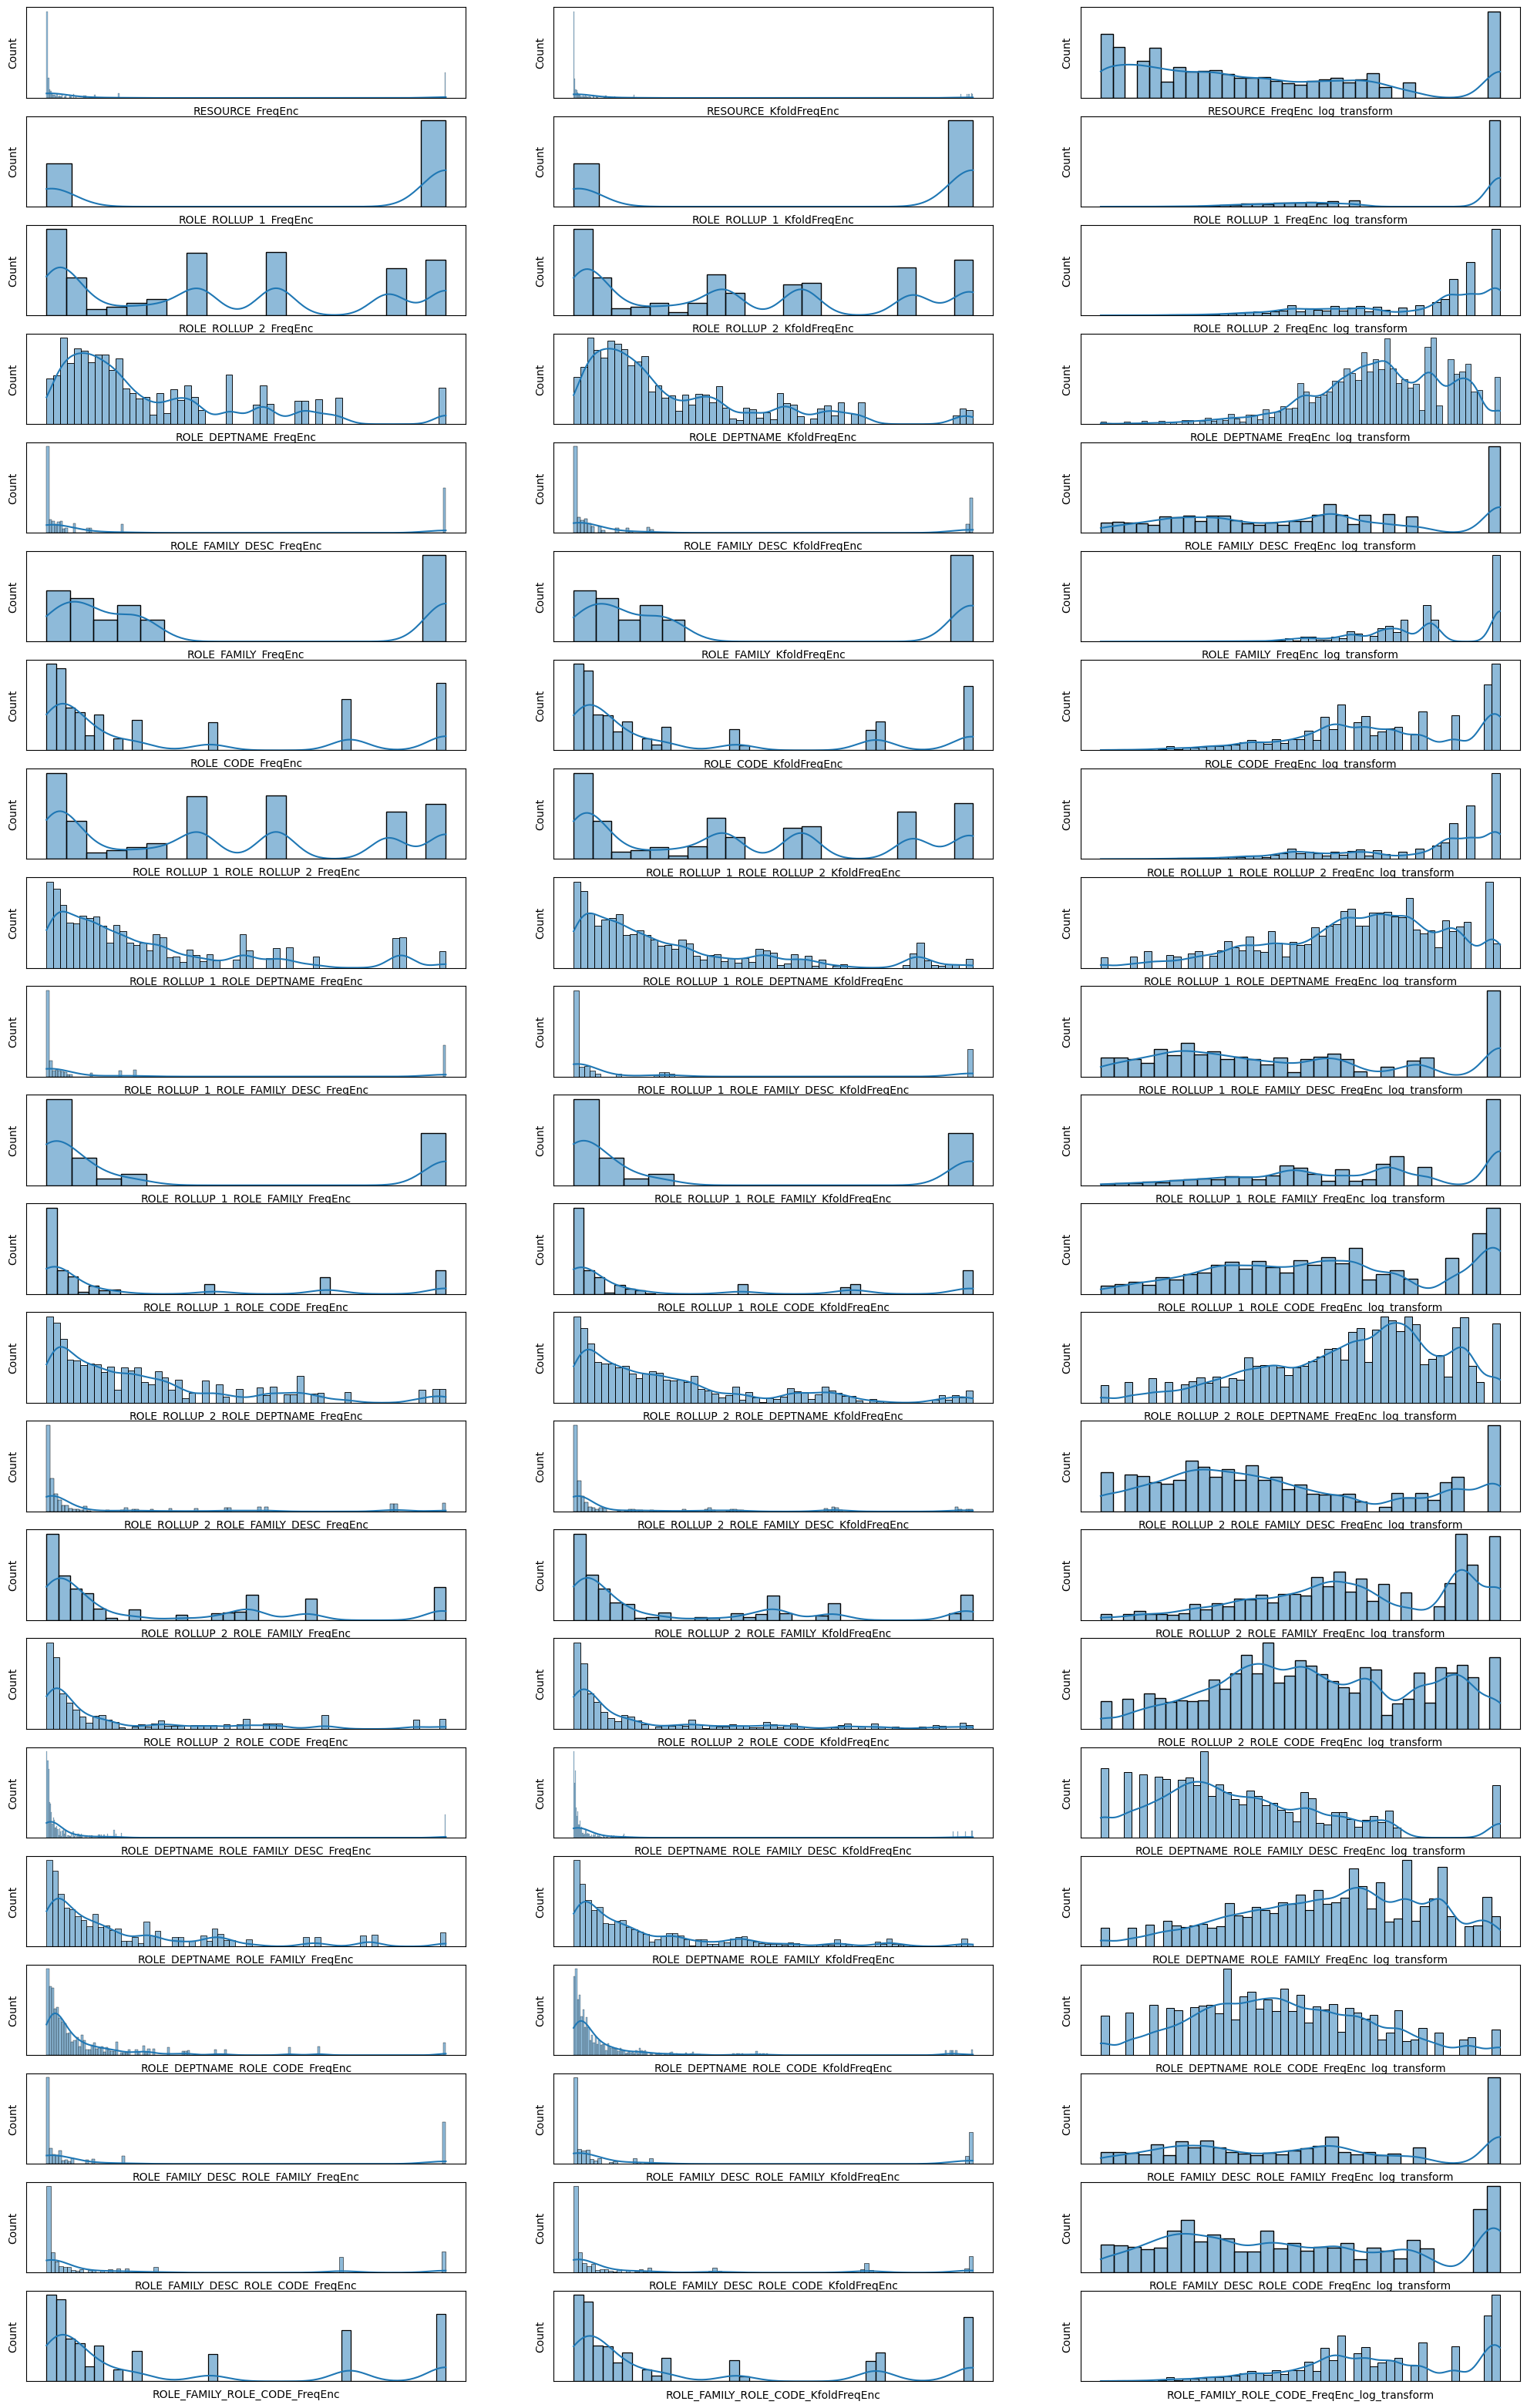

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(25,40))
plot_index = 1
for i in range(0, transform_feq_enc_scale.shape[1]):

    axes = plt.subplot(22, 3, plot_index)
    sns.histplot(transform_feq_enc_scale[transform_feq_enc_scale.columns[i]], kde = True, ax = axes)
    #axes.set_title(transform_feq_enc_scale.columns[i])
    axes.xaxis.set_major_locator(ticker.NullLocator())
    axes.yaxis.set_major_locator(ticker.NullLocator())

    plot_index+=1
    axes = plt.subplot(22, 3, plot_index)
    sns.histplot(transform_kfeq_scale[transform_kfeq_scale.columns[i]], kde = True, ax = axes)
    #axes.set_title(transform_feq_enc_scale.columns[i])
    axes.xaxis.set_major_locator(ticker.NullLocator())
    axes.yaxis.set_major_locator(ticker.NullLocator())

    plot_index+=1    
    axes = plt.subplot(22, 3, plot_index)
    sns.histplot(transform_feq_log[transform_feq_log.columns[i]], kde = True, ax = axes)
    #axes.set_title(transform_feq_enc_scale.columns[i])
    axes.xaxis.set_major_locator(ticker.NullLocator())
    axes.yaxis.set_major_locator(ticker.NullLocator())

    plot_index+=1

plt.show()

In [ ]:

#for i in range(0, transform_feq_enc_scale.shape[1]):
#    sns.histplot(transform_feq_enc_scale[transform_feq_enc_scale.columns[i]], kde = True, ax = plt.subplot(5, 5, i+1))

#for i in range(0, transform_kfeq_scale.shape[1]):
#    sns.histplot(transform_kfeq_scale[transform_kfeq_scale.columns[i]], kde = True, ax = plt.subplot(5, 5, i+1))

**Observation**

* Frequency encoding and KFold Frequency Encoding output similar result. As most of the unique records have same freqency counts.
* When applied log transformation we see spread in our data that might help to generalize the model.

Let's explore more on log transformed data

    Log transform features we can consider:
    * ROLE_FAMILY_ROLE_CODE and ROLE_FAMILY_DESC_ROLE_CODE,  ROLE_FAMILY_DESC_ROLE_FAMILY similar distrubition 
    * ROLE_DEPTNAME_ROLE_CODE
ROLE_DEPTNAME_ROLE_FAMILY
ROLE_DEPTNAME_ROLE_FAMILY_DESC
ROLE_ROLLUP_2_ROLE_CODE
ROLE_ROLLUP_2_ROLE_FAMILY
ROLE_ROLLUP_2_ROLE_FAMILY_DESC
ROLE_ROLLUP_2_ROLE_DEPTNAME
ROLE_ROLLUP_1_ROLE_CODE & ROLE_ROLLUP_ROLE_FAMILY & ROLE_ROLLUP_1_ROLE_FAMILY_DESC have same distrubution
ROLE_ROLLUP_1_ROLE_DEPTNAME
ROLE_ROLLUP_1_ROLE_ROLLUP_2 & ROLE_CODE & ROLE_FAMILY have same dist
ROLE_FAMILY_DESC
ROLE_DEPTNAME -  We see spread in our data

ROLE_ROLLUP_1 & ROLE_ROLLUP_2 result in similay dist
RESOURCE


#### Log Transform Frequency Encoding ####

##### Explore which features of Log Transform to consider #####

In [ ]:
"""
fig = plt.figure(figsize=(15, 20))

plot_index = 1
axes = plt.subplot(22, 3, plot_index)
sns.histplot(transform_feq_log['ROLE_FAMILY_ROLE_CODE_FreqEnc_log_transform'], kde = True, ax = axes)
plot_index+=1
axes = plt.subplot(22, 3, plot_index)
sns.histplot(transform_feq_log['ROLE_FAMILY_DESC_ROLE_CODE_FreqEnc_log_transform'], kde = True, ax = axes)
plot_index+=1    
axes = plt.subplot(22, 3, plot_index)
sns.histplot(transform_feq_log['ROLE_FAMILY_DESC_ROLE_FAMILY_FreqEnc_log_transform'], kde = True, ax = axes)


plt.show()
"""


#fig = plt.figure(figsize=(25,15))
#for i in range(0, transform_feq_log.shape[1]):
#    sns.histplot(transform_feq_log[transform_feq_log.columns[i]], kde = True, ax = plt.subplot(5, 5, i+1))

#plt.show()

"\nfig = plt.figure(figsize=(15, 20))\n\nplot_index = 1\naxes = plt.subplot(22, 3, plot_index)\nsns.histplot(transform_feq_log['ROLE_FAMILY_ROLE_CODE_FreqEnc_log_transform'], kde = True, ax = axes)\nplot_index+=1\naxes = plt.subplot(22, 3, plot_index)\nsns.histplot(transform_feq_log['ROLE_FAMILY_DESC_ROLE_CODE_FreqEnc_log_transform'], kde = True, ax = axes)\nplot_index+=1    \naxes = plt.subplot(22, 3, plot_index)\nsns.histplot(transform_feq_log['ROLE_FAMILY_DESC_ROLE_FAMILY_FreqEnc_log_transform'], kde = True, ax = axes)\n\n\nplt.show()\n"

In [ ]:
#Log transform on KFold-Frequency Encode
transform_kfeq_log = np.log10(transform_kfeq)

renamed_col = []
for col in transform_kfeq_log.columns:
    renamed_col.append(col + "_log_transform")

transform_kfeq_log.columns = renamed_col
transform_kfeq_log.head()


#fig = plt.figure(figsize=(25,15))
#for i in range(0, transform_kfeq_log.shape[1]):
#   sns.histplot(transform_kfeq_log[transform_kfeq_log.columns[i]], kde = True, ax = plt.subplot(5, 5, i+1))

#plt.show()


RESOURCE_KfoldFreqEnc_log_transform  \
0                             0.301030   
1                             1.361728   
2                             3.548635   
3                             0.000000   
4                             0.845098   

   ROLE_ROLLUP_1_KfoldFreqEnc_log_transform  \
0                                  4.208092   
1                                  4.209515   
2                                  2.103804   
3                                  4.209515   
4                                  2.214844   

   ROLE_ROLLUP_2_KfoldFreqEnc_log_transform  \
0                                  3.526598   
1                                  3.463744   
2                                  2.103804   
3                                  3.463744   
4                                  1.913814   

   ROLE_DEPTNAME_KfoldFreqEnc_log_transform  \
0                                  1.740363   
1                                  2.120574   
2                                  2.495544   
3                                  2.204120   
4                                  1.477121   

   ROLE_FAMILY_DESC_KfoldFreqEnc_log_transform  \
0                                     3.689575   
1                                     1.000000   
2                                     1.431364   
3                                     2.980003   
4                                     1.079181   

   ROLE_FAMILY_KfoldFreqEnc_log_transform  \
0                                3.905850   
1                                3.008600   
2                                3.250176   
3                                3.908431   
4                                2.445604   

   ROLE_CODE_KfoldFreqEnc_log_transform  \
0                              3.407391   
1                              1.845098   
2                              2.865104   
3                              3.528016   
4                              1.716003   

   ROLE_ROLLUP_1_ROLE_ROLLUP_2_KfoldFreqEnc_log_transform  \
0                                           3.526598        
1                                           3.463744        
2                                           2.103804        
3                                           3.463744        
4                                           1.913814        

   ROLE_ROLLUP_1_ROLE_DEPTNAME_KfoldFreqEnc_log_transform  \
0                                           1.698970        
1                                           2.008600        
2                                           0.903090        
3                                           2.178977        
4                                           1.113943        

   ROLE_ROLLUP_1_ROLE_FAMILY_DESC_KfoldFreqEnc_log_transform  ...  \
0                                           3.617629          ...   
1                                           1.000000          ...   
2                                           2.987666          ...   
3                                           2.969416          ...   
4                                           0.845098          ...   

   ROLE_ROLLUP_2_ROLE_DEPTNAME_KfoldFreqEnc_log_transform  \
0                                           1.698970        
1                                           2.000000        
2                                           0.903090        
3                                           2.149219        
4                                           1.041393        

   ROLE_ROLLUP_2_ROLE_FAMILY_DESC_KfoldFreqEnc_log_transform  \
0                                           2.882525           
1                                           0.602060           
2                                           3.061452           
3                                           2.309630           
4                                           0.778151           

   ROLE_ROLLUP_2_ROLE_FAMILY_KfoldFreqEnc_log_transform  \
0                                           3.092721      
1                                           2.25042

In [ ]:
transform_kfeq_log.head()

RESOURCE_KfoldFreqEnc_log_transform  \
0                             0.301030   
1                             1.361728   
2                             3.548635   
3                             0.000000   
4                             0.845098   

   ROLE_ROLLUP_1_KfoldFreqEnc_log_transform  \
0                                  4.208092   
1                                  4.209515   
2                                  2.103804   
3                                  4.209515   
4                                  2.214844   

   ROLE_ROLLUP_2_KfoldFreqEnc_log_transform  \
0                                  3.526598   
1                                  3.463744   
2                                  2.103804   
3                                  3.463744   
4                                  1.913814   

   ROLE_DEPTNAME_KfoldFreqEnc_log_transform  \
0                                  1.740363   
1                                  2.120574   
2                                  2.495544   
3                                  2.204120   
4                                  1.477121   

   ROLE_FAMILY_DESC_KfoldFreqEnc_log_transform  \
0                                     3.689575   
1                                     1.000000   
2                                     1.431364   
3                                     2.980003   
4                                     1.079181   

   ROLE_FAMILY_KfoldFreqEnc_log_transform  \
0                                3.905850   
1                                3.008600   
2                                3.250176   
3                                3.908431   
4                                2.445604   

   ROLE_CODE_KfoldFreqEnc_log_transform  \
0                              3.407391   
1                              1.845098   
2                              2.865104   
3                              3.528016   
4                              1.716003   

   ROLE_ROLLUP_1_ROLE_ROLLUP_2_KfoldFreqEnc_log_transform  \
0                                           3.526598        
1                                           3.463744        
2                                           2.103804        
3                                           3.463744        
4                                           1.913814        

   ROLE_ROLLUP_1_ROLE_DEPTNAME_KfoldFreqEnc_log_transform  \
0                                           1.698970        
1                                           2.008600        
2                                           0.903090        
3                                           2.178977        
4                                           1.113943        

   ROLE_ROLLUP_1_ROLE_FAMILY_DESC_KfoldFreqEnc_log_transform  ...  \
0                                           3.617629          ...   
1                                           1.000000          ...   
2                                           2.987666          ...   
3                                           2.969416          ...   
4                                           0.845098          ...   

   ROLE_ROLLUP_2_ROLE_DEPTNAME_KfoldFreqEnc_log_transform  \
0                                           1.698970        
1                                           2.000000        
2                                           0.903090        
3                                           2.149219        
4                                           1.041393        

   ROLE_ROLLUP_2_ROLE_FAMILY_DESC_KfoldFreqEnc_log_transform  \
0                                           2.882525           
1                                           0.602060           
2                                           3.061452           
3                                           2.309630           
4                                           0.778151           

   ROLE_ROLLUP_2_ROLE_FAMILY_KfoldFreqEnc_log_transform  \
0                                           3.092721      
1                                           2.25042

In [ ]:
transform_feq_log.head()

RESOURCE_FreqEnc_log_transform  ROLE_ROLLUP_1_FreqEnc_log_transform  \
0                        0.477121                             4.305781   
1                        1.447158                             4.305781   
2                        0.301030                             2.227887   
3                        3.582291                             4.305781   
4                        0.903090                             2.340444   

   ROLE_ROLLUP_2_FreqEnc_log_transform  ROLE_DEPTNAME_FreqEnc_log_transform  \
0                             3.627161                             1.845098   
1                             3.560026                             2.190332   
2                             2.227887                             2.598791   
3                             3.560026                             2.269513   
4                             2.033424                             1.643453   

   ROLE_FAMILY_DESC_FreqEnc_log_transform  ROLE_FAMILY_FreqEnc_log_transform  \
0                                3.787673                           4.003374   
1                                1.079181                           3.105169   
2                                1.518514                           3.344392   
3                                3.068928                           4.003374   
4                                1.255273                           2.553883   

   ROLE_CODE_FreqEnc_log_transform  \
0                         3.504335   
1                         1.908485   
2                         2.968483   
3                         3.623353   
4                         1.869232   

   ROLE_ROLLUP_1_ROLE_ROLLUP_2_FreqEnc_log_transform  \
0                                           3.627161   
1                                           3.560026   
2                                           2.227887   
3                                           3.560026   
4                                           2.033424   

   ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc_log_transform  \
0                                           1.806180   
1                                           2.082785   
2                                           1.113943   
3                                           2.240549   
4                                           1.342423   

   ROLE_ROLLUP_1_ROLE_FAMILY_DESC_FreqEnc_log_transform  ...  \
0                                           3.718253     ...   
1                                           1.079181     ...   
2                                           0.301030     ...   
3                                           3.058046     ...   
4                                           1.000000     ...   

   ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc_log_transform  \
0                                           1.806180   
1                                           2.075547   
2                                           1.113943   
3                                           2.209515   
4                                           1.255273   

   ROLE_ROLLUP_2_ROLE_FAMILY_DESC_FreqEnc_log_transform  \
0                                           2.988113      
1                                           0.698970      
2                                           0.301030      
3                                           2.382017      
4                                           0.903090      

   ROLE_ROLLUP_2_ROLE_FAMILY_FreqEnc_log_transform  \
0                                         3.194514   
1                                         2.350248   
2                                         2.049218   
3                                         3.186108   
4                                         0.954243   

   ROLE_ROLLUP_2_ROLE_CODE_FreqEnc_log_transform  \
0                                       2.607455   
1                                       1.278754   
2                                       1.643453   
3                                       2.818885   
4                                    

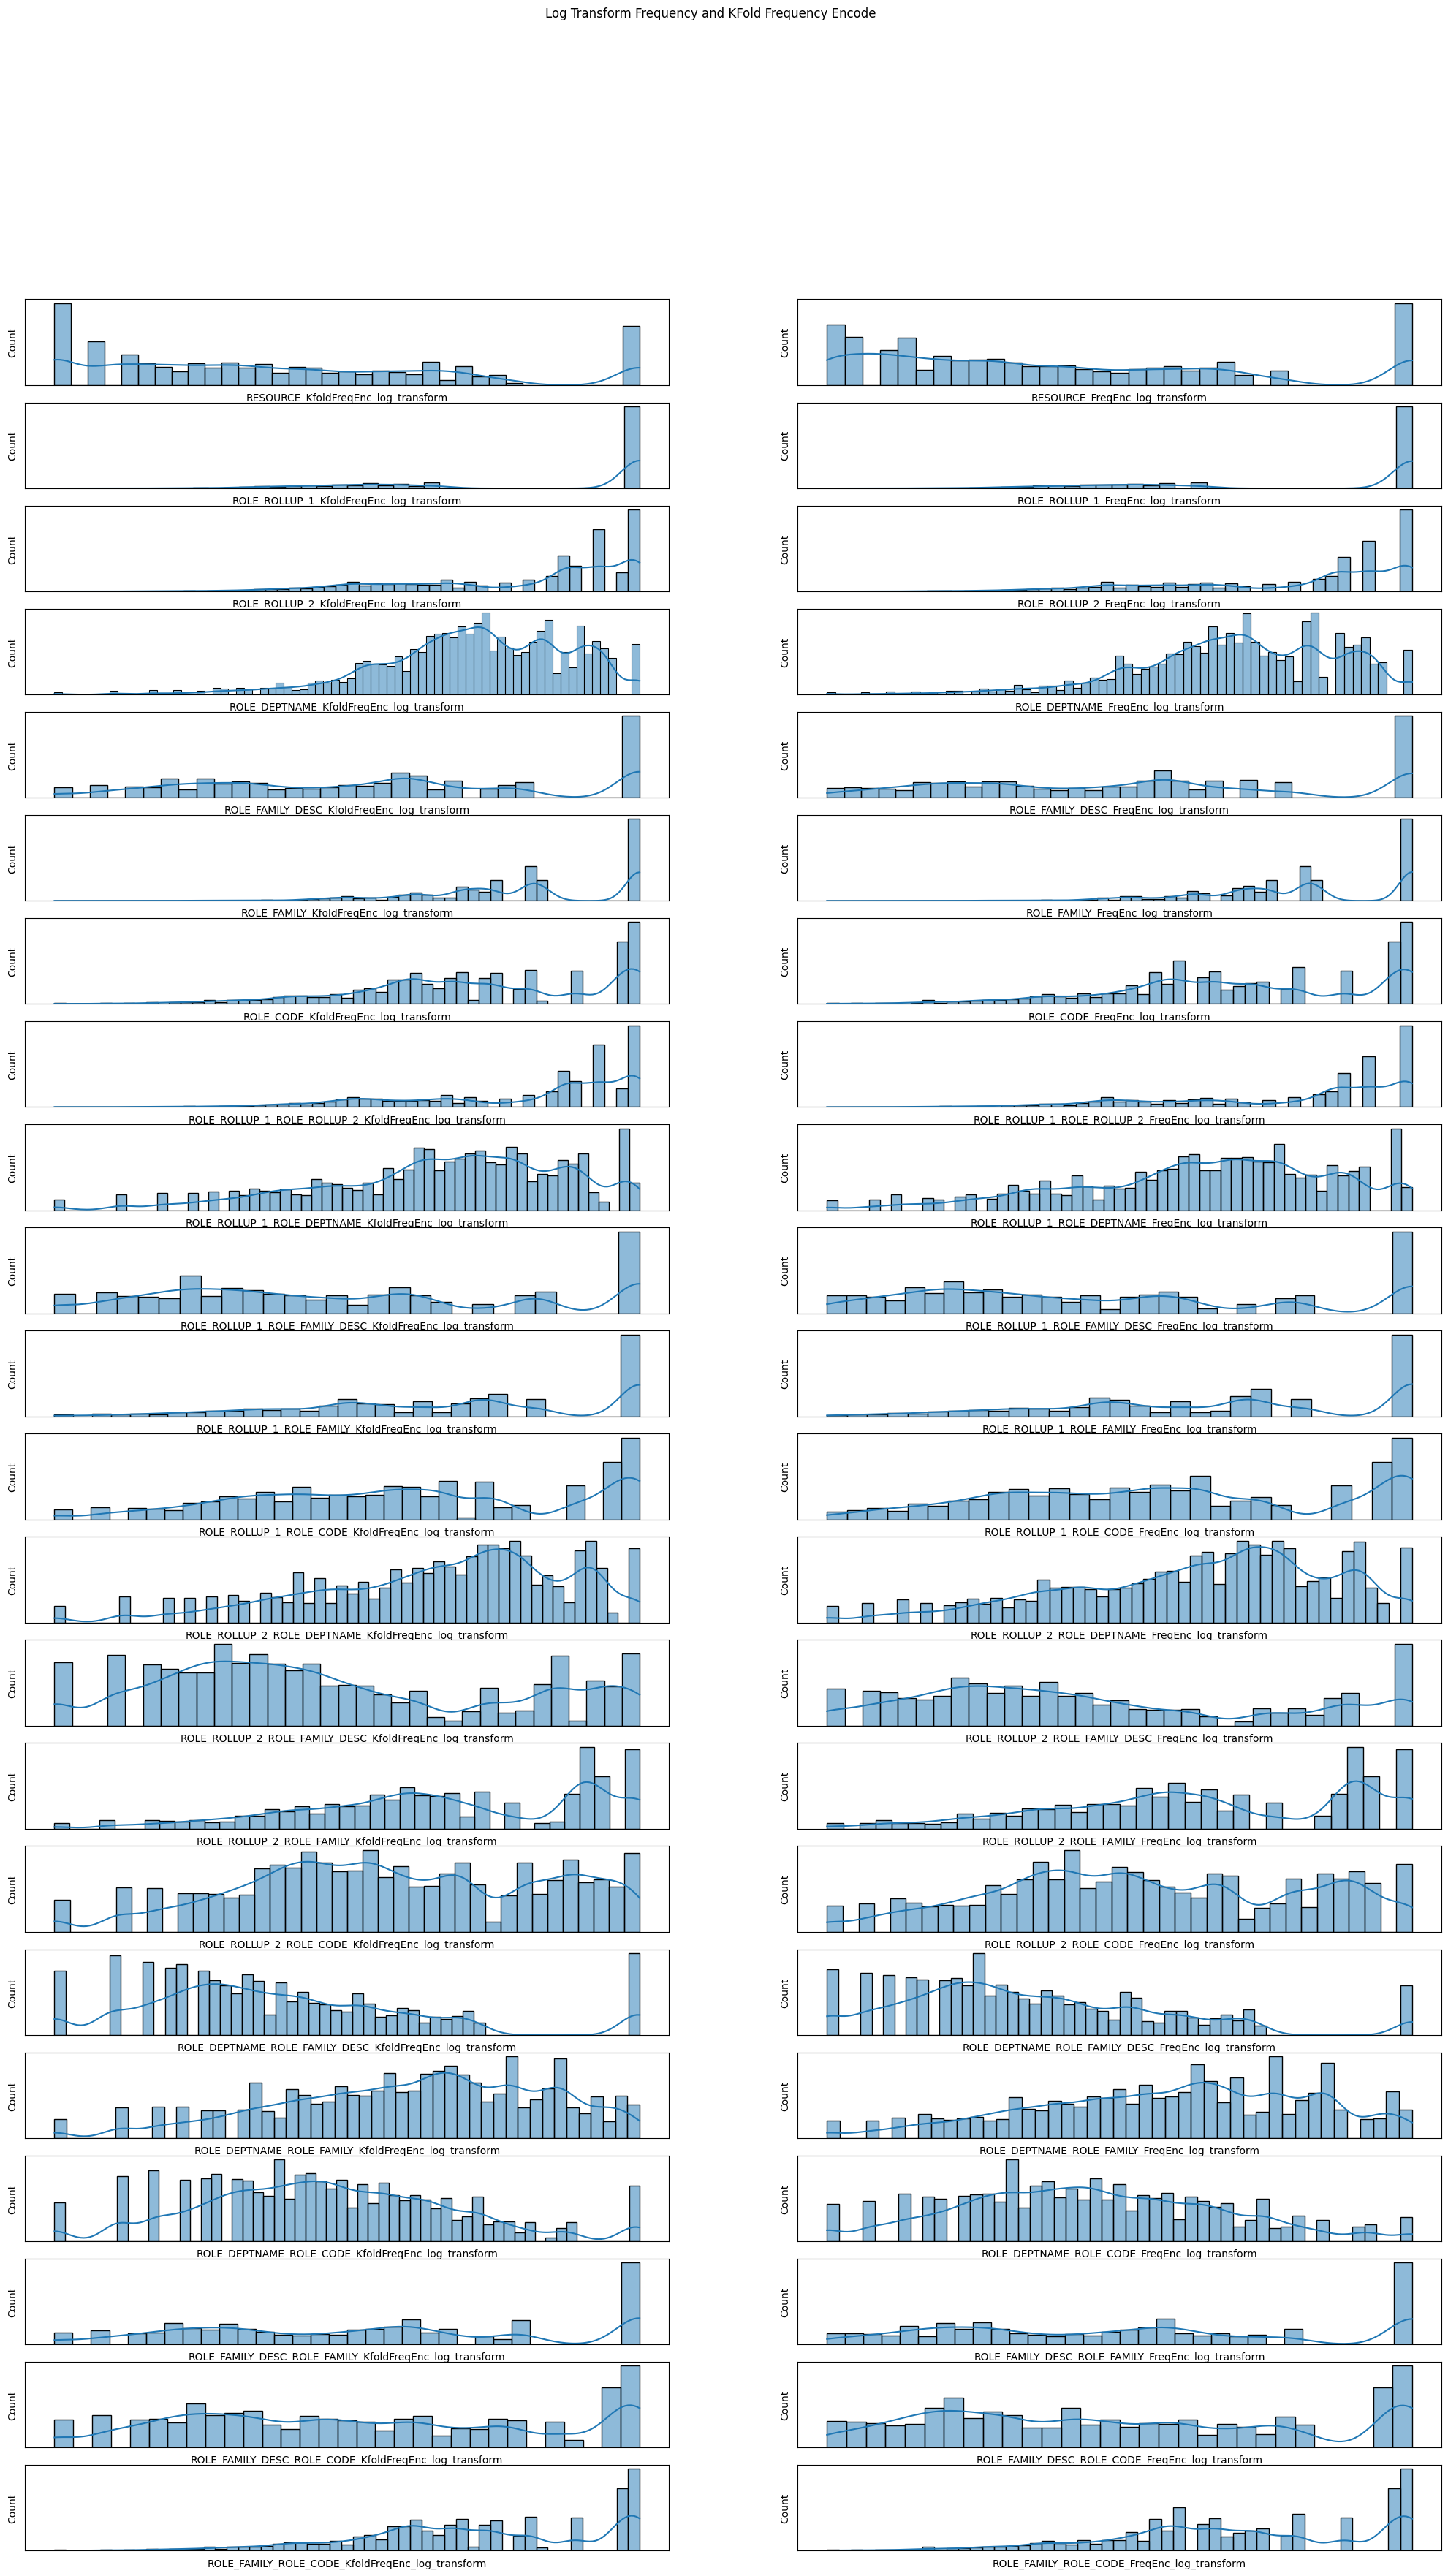

In [ ]:
fig = plt.figure(figsize=(25,40))
#fig.subplots_adjust(hspace=0.4, top=0.85) # Add a margin between the main title and sub-plots
fig.suptitle("Log Transform Frequency and KFold Frequency Encode") #, fontsize=15 # Add the main title

plot_index = 1

for i in range(0, transform_kfeq_log.shape[1]):

    axes = plt.subplot(22, 2, plot_index)
    sns.histplot(transform_kfeq_log[transform_kfeq_log.columns[i]], kde = True, ax = axes)
    axes.xaxis.set_major_locator(ticker.NullLocator())
    axes.yaxis.set_major_locator(ticker.NullLocator())

    plot_index+=1
    axes = plt.subplot(22, 2, plot_index)
    sns.histplot(transform_feq_log[transform_feq_log.columns[i]], kde = True, ax = axes)
    axes.xaxis.set_major_locator(ticker.NullLocator())
    axes.yaxis.set_major_locator(ticker.NullLocator())

    plot_index+=1

plt.show()

**Observation:**
- Frequency Encode seam to perform better distrubution is most of the case compare to kFold Frequency Encode.
- Feature that are in combination of ROLE_DEPTNAME we see good distribution in both the log transform.
    * Feature to consider are:
        - ROLE_DEPTNAME (kfold freq has some what better distrubution then freq)
        - ROLE_ROLLUP_1_ROLE_DEPTNAME
        - ROLE_ROLLUP_2_ROLE_DEPTNAME
        - ROLE_ROLLUP_2_ROLE_CODE
        - ROLE_DEPTNAME_ROLE_FAMILY_DESC
        - ROLE_DEPTNAME_ROLE_FAMILY
        - ROLE_DEPTNAME_ROLE_CODE

C:\Users\smithau8\AppData\Local\Temp\ipykernel_1380\657256981.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 2500x4000 with 0 Axes>

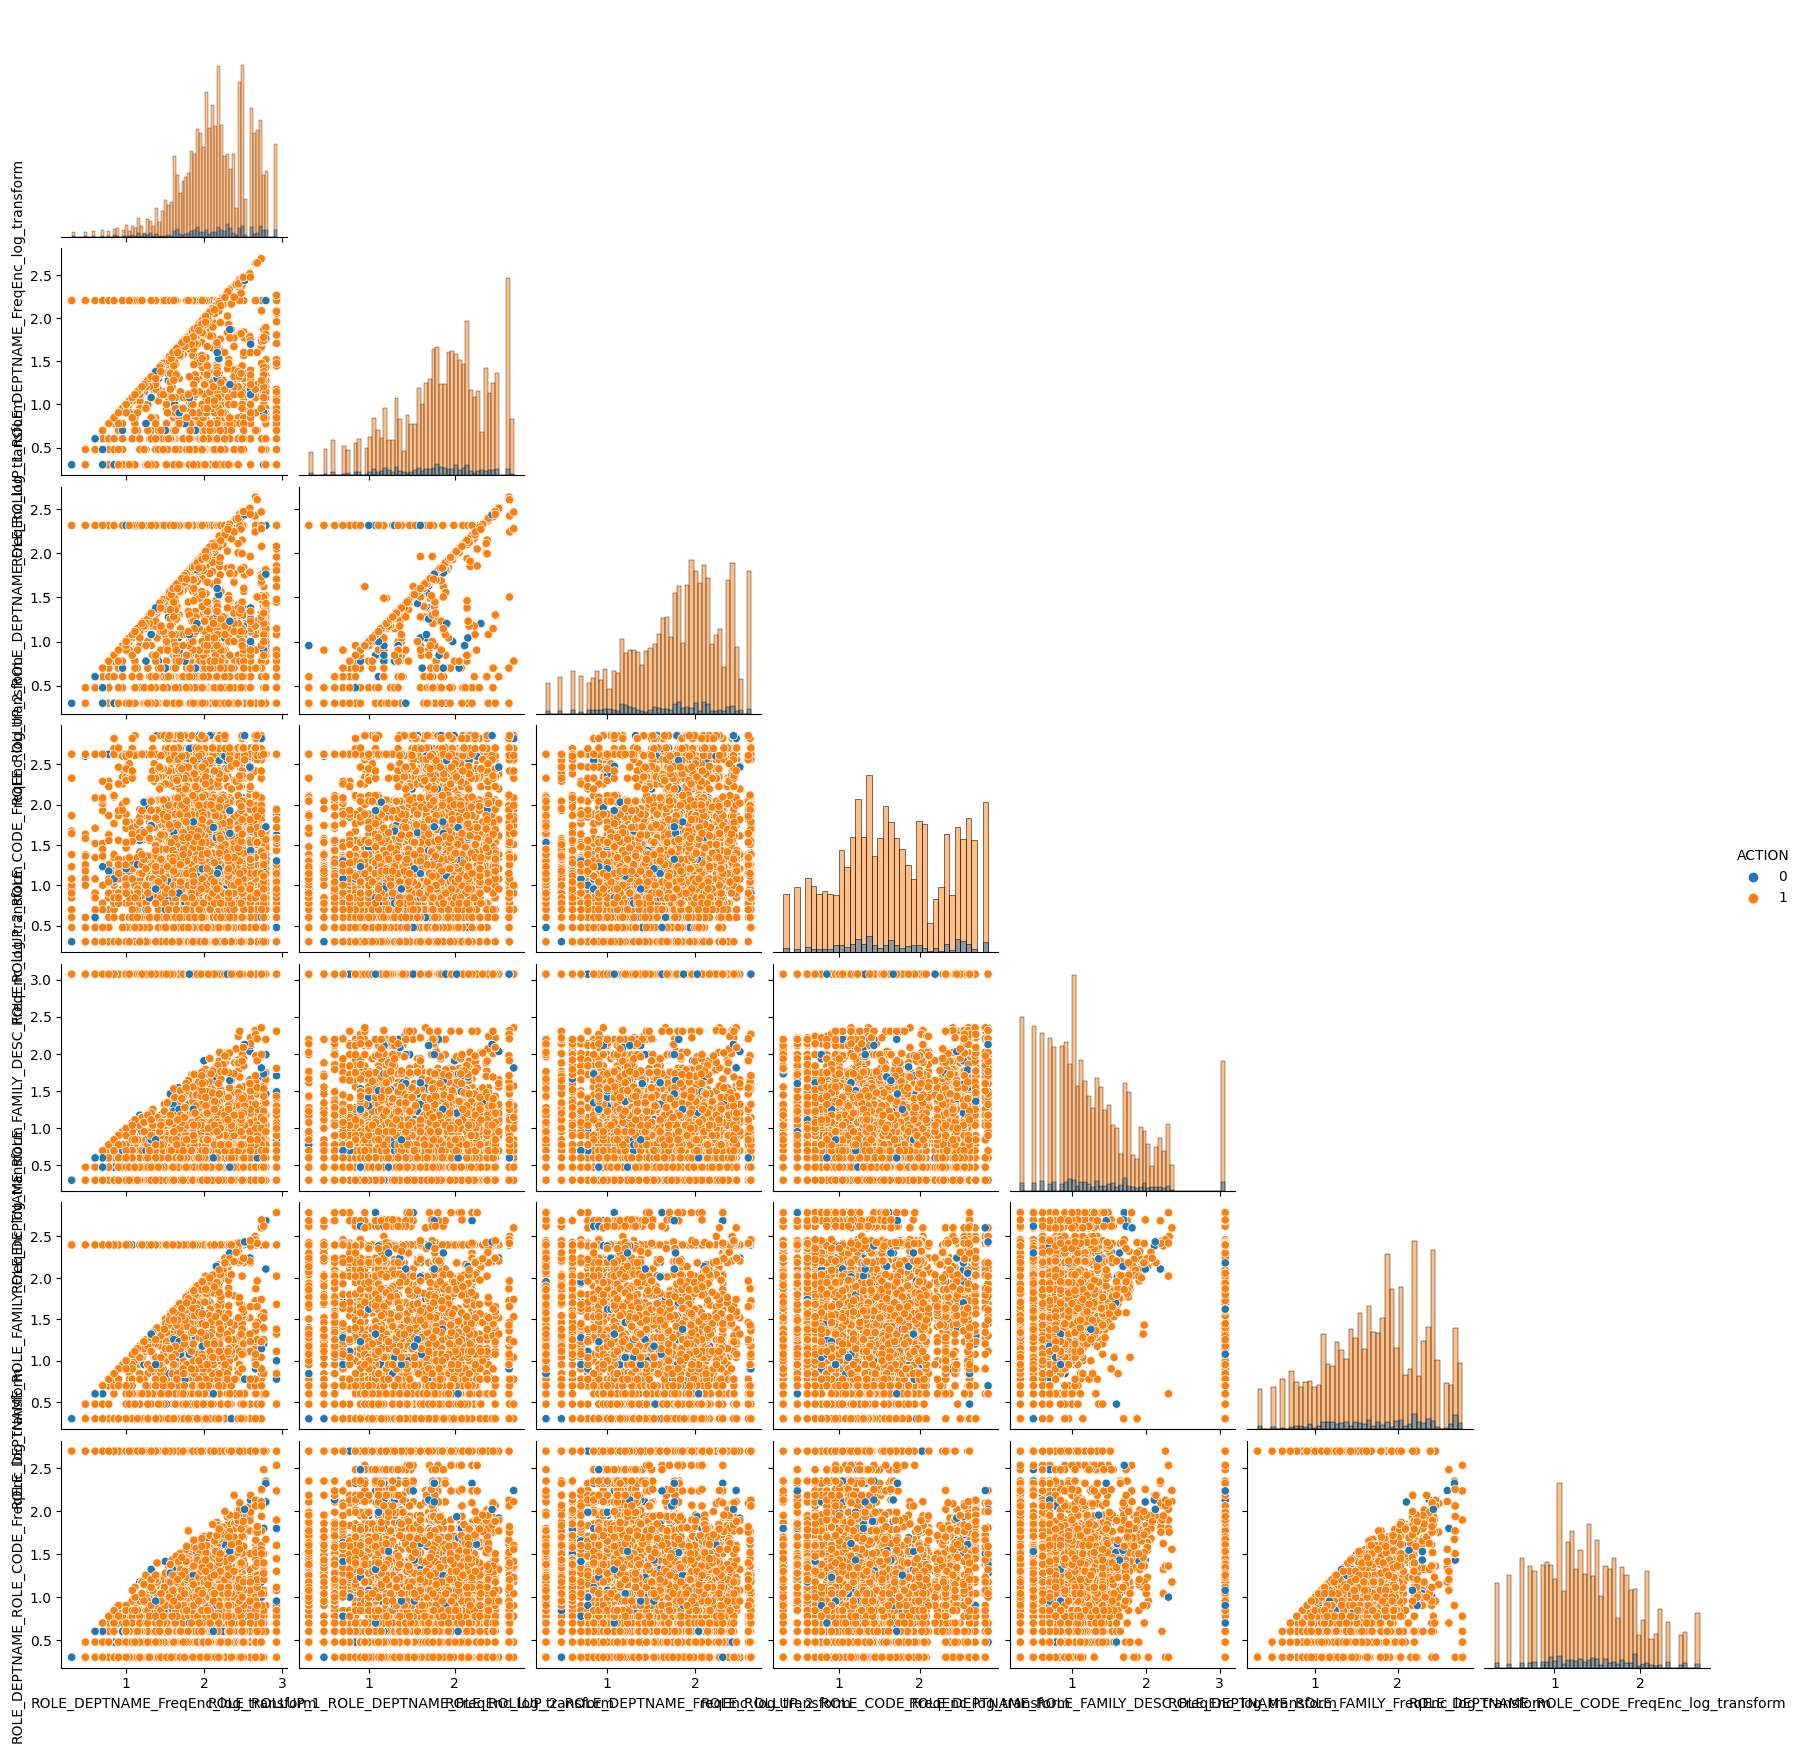

In [ ]:
#Pair plot
fig = plt.figure(figsize=(25,40))

transform_feq_log['ACTION'] = train.ACTION
selected_cols = ['ROLE_DEPTNAME', 'ROLE_ROLLUP_1_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC', 'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE']

for i in range(len(selected_cols)):
    selected_cols[i] = selected_cols[i] + '_FreqEnc_log_transform' #Update an element in the list

#selected_cols.append('ACTION')
sns.pairplot(transform_feq_log, vars = selected_cols, hue = 'ACTION', diag_kind = "hist", corner = True)

fig.show()

##### Create Log Transform Frequency Encoding Pipeline for testing  #####

In [ ]:

#Pipeline
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from utils.read_utils import read_from_parquet
from sklearn.preprocessing import FunctionTransformer
from src.models.feature_eng.RandomCatagoryEncode import RandomCatagoryEncode
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

train = read_from_parquet(train_data)

freq_enc_cols = ['ROLE_DEPTNAME', 'ROLE_ROLLUP_1_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC', 'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE']

for i in range(len(freq_enc_cols)):
    freq_enc_cols[i] = freq_enc_cols[i] + '_FreqEnc'

feature_engg = Pipeline(steps = [
                        ('combine_feature', CombineFeatures()), #This step is always required
                        ('frequency_encoding', FrequencyEncoding()),
                        #('log_transform', ColumnTransformer(transformers = [("log_transform_freq_enc_log", FunctionTransformer(np.log10), freq_enc_cols)])),
                        #('Random_Catagory_Encode', RandomCatagoryEncode()),
                        ]
                        ) 

X = feature_engg.fit_transform(train)

print(X.shape)
X.head()

(30391, 32)


ACTION RESOURCE  MGR_ID ROLE_ROLLUP_1 ROLE_ROLLUP_2 ROLE_DEPTNAME  \
0           1    39353   85475        117961        118300        123472   
1           1    17183    1540        117961        118343        123125   
2           1    36724   14457        118219        118220        117884   
3           1    36135    5396        117961        118343        119993   
4           1    42680    5905        117929        117930        119569   
...       ...      ...     ...           ...           ...           ...   
32764       1    23497   16971        117961        118300        119993   
32765       1    25139  311198         91261        118026        122392   
32766       1    34924   28805        117961        118327        120299   
32767       1    80574   55643        118256        118257        117945   
32768       1    14354   59575        117916        118150        117920   

      ROLE_TITLE ROLE_FAMILY_DESC ROLE_FAMILY ROLE_CODE  ...  \
0         117905           117906      290919    117908  ...   
1         118536           118536      308574    118539  ...   
2         117879           267952       19721    117880  ...   
3         118321           240983      290919    118322  ...   
4         119323           123932       19793    119325  ...   
...          ...              ...         ...       ...  ...   
32764     118321           240983      290919    118322  ...   
32765     121143           173805      249618    121145  ...   
32766     124922           152038      118612    124924  ...   
32767     280788           280788      292795    119082  ...   
32768     118568           122142       19721    118570  ...   

      ROLE_FAMILY_DESC_ROLE_FAMILY ROLE_FAMILY_DESC_ROLE_CODE  \
0                    117906 290919              117906 117908   
1                    118536 308574              118536 118539   
2                     267952 19721              267952 117880   
3                    240983 290919              240983 118322   
4                     123932 19793              123932 119325   
...                            ...                        ...   
32764                240983 290919              240983 118322   
32765                173805 249618              173805 121145   
32766                152038 118612              152038 124924   
32767                280788 292795              280788 119082   
32768                 122142 19721              122142 118570   

      ROLE_FAMILY_ROLE_CODE ROLE_DEPTNAME_FreqEnc  \
0             290919 117908              1.845098   
1             308574 118539              2.190332   
2              19721 117880              2.598791   
3             290919 118322              2.269513   
4              19793 119325              1.643453   
...                     ...                   ...   
32764         290919 118322              2.269513   
32765         249618 121145              1.732394   
32766         118612 124924              1.612784   
32767         292795 119082              2.739572   
32768          19721 118570              2.767898   

      ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc  \
0                                1.806180                            1.806180   
1                                2.082785                            2.075547   
2                                1.113943                            1.113943   
3                                2.240549                            2.209515   
4                                1.342423                            1.255273   
...                                   ...                                 ...   
32764                            2.240549                            1.079181   
32765                            0.954243                            0.954243   
32766                            1.447158                            1.447158   
32767                            2.086360                            2.079181   
32768           

In [ ]:
X.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)
feature_columns = X.select_dtypes(exclude = ['object']).columns 
feature_columns

Index(['ACTION', 'ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_CODE_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc', 'ROLE_DEPTNAME_ROLE_CODE_FreqEnc'],
      dtype='object')

In [ ]:
#Remove 'ROLE_FAMILY_ROLE_CODE' from the combination feature
#nq.drop(nq[nq.group_by_feature.isin( target_col + ["ROLE_FAMILY_ROLE_CODE"])].index, axis = 0, inplace = True)
#train.drop(["ROLE_FAMILY_ROLE_CODE"], inplace = True,axis = 1)

#Initial thought to consider only those feature where nunique is less then 5000
#Lets keep this as input paramater when featurizing.
#col_unique_under_threshold = nq[nq.num_unique<5000].group_by_feature.tolist()
#col_unique_under_threshold = nq[~nq.group_by_feature.isin(col_use)].group_by_feature.tolist()
#col_unique_under_threshold = nq.group_by_feature.tolist()
#col_unique_under_threshold.remove("ROLE_FAMILY_ROLE_CODE")
#col_unique_under_threshold.remove("ACTION")

#del nq
#gc.collect()

#col_unique_under_threshold

#train[col_unique_under_threshold].head(2)

### Count/TDIF Vectorisation ###

In [ ]:
# Code Source: https://www.kaggle.com/code/rahulpatel11315/selecting-the-best-number-of-components-for-tsvd
from sklearn.decomposition import TruncatedSVD
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_col_interaction(dataset, col1, col2, tfif = False):

    key = col1 + "_" + col2
    
    #params = kwargs['params']
    data = dataset.groupby([col1])[col2].agg(lambda x: " ".join(x))

    if tfif == False:
        if key in dict_Vectorizer:
            vectorizer = dict_Vectorizer[key]
        else:
            vectorizer = CountVectorizer(lowercase = False)            
            dict_Vectorizer[key] = vectorizer.fit(data) #Save the fitted vectorizer obj, which will be used in the transform stage
    else:
        if key in dict_Vectorizer:
            vectorizer = dict_Vectorizer[key]
        else:
            vectorizer = TfidfVectorizer(lowercase = False)            
            dict_Vectorizer[key] = vectorizer.fit(data)
        
    data_X = vectorizer.transform(data)

    if key in dict_dim_reduction:
        dim_red = dict_dim_reduction[key] 
    else:
        dim_red = round(data_X.shape[1]/2)
        print(f'Vectorize of {col1} & {col2} shape: {data_X.shape}, reduce to {dim_red}')
        
        dim_red = TruncatedSVD(n_components = dim_red, random_state = params['random_seed'])
        
        dict_dim_reduction[key] = dim_red.fit(data_X) 

        #Save the fitted dimension reduction obj, which will be used in the transform stage
        #dim_red = dim_red.fit(data_X) 

        #if dim_red.explained_variance_ratio_[0] >= 0.9:
        #    dict_dim_reduction[key] = dim_red
        #else:
        #    del dict_Vectorizer[key]
        #    return None

        

#### Count Vectorizer Encoding #### 

In [ ]:
params = hlpread.read_yaml_key('featurize.count_vector')

In [ ]:
dict_Vectorizer = {}
dict_dim_reduction = {}

for col1, col2 in permutations(train.columns, 2):

    if (col1 == targetcol) | (col2 == targetcol):
        continue

    extract_col_interaction(train, col1, col2)

##### Selecting the best number of components for TSVD #####

In [ ]:
# variances for RESOURCE and ROLE_ROLLUP_1 combination
tsvd_var_ratios = dict_dim_reduction['RESOURCE_ROLE_ROLLUP_1'].explained_variance_ratio_
#tsvd_var_ratios

select_n_components(tsvd_var_ratios, 0.95)

1

In [ ]:
# For each keys get the dim(no of components) that can explain variation ratios of 0.95
n_componets_dim = {}
end_dataset_dim = 0
for key in dict_dim_reduction.keys():
    n_componets_dim[key] = select_n_components(dict_dim_reduction[key].explained_variance_ratio_, 0.95)
    end_dataset_dim += n_componets_dim[key]
n_componets_dim

{'RESOURCE_ROLE_ROLLUP_1': 1,
 'RESOURCE_ROLE_ROLLUP_2': 20,
 'RESOURCE_ROLE_DEPTNAME': 28,
 'RESOURCE_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_FAMILY': 7,
 'RESOURCE_ROLE_CODE': 28,
 'RESOURCE_RESOURCE_ROLE_ROLLUP_1': 28,
 'RESOURCE_RESOURCE_ROLE_ROLLUP_2': 28,
 'RESOURCE_RESOURCE_ROLE_DEPTNAME': 28,
 'RESOURCE_RESOURCE_ROLE_FAMILY_DESC': 28,
 'RESOURCE_RESOURCE_ROLE_FAMILY': 28,
 'RESOURCE_RESOURCE_ROLE_CODE': 28,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_ROLLUP_2': 8,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_DEPTNAME': 16,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_FAMILY_DESC': 4,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_FAMILY': 6,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_CODE': 6,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_DEPTNAME': 28,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_FAMILY': 18,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_CODE': 28,
 'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY': 28,
 'RESOURCE_ROLE_DEPTNAME_ROLE_CODE': 28,
 'RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY': 15,
 'RESOURC

In [ ]:
end_dataset_dim

12016

In [ ]:
len(n_componets_dim)

721

***Note***: If we consider number of components/dim for each feature that explain variance 95% then we will endup with dataset that will have 12016 feature. Which is too large.

In [ ]:
#Which features can explain 95% variance with 1 dim/n_components

"""
vaiance_dim = {}
for key in dict_dim_reduction.keys():
    vaiance_dim[key] = dict_dim_reduction[key].explained_variance_ratio_[0]
#vaiance_dim

#Filter out combination that explain at least 95% of the varaiance with one 1 dims
i = 0
features_95_variance = []
for (key, value) in vaiance_dim.items(): 
    if value >= 0.95:
        features_95_variance.append(key)
        i+=1
print(i)
"""

i = 0
features_90_variance = []
var = 0.90
for key in dict_dim_reduction.keys():
    if dict_dim_reduction[key].explained_variance_ratio_[0] >= var:
        features_90_variance.append(key)
        i+=1
print(f'Number of new output feature with the varaiance of {var}: {i}.')

Number of new output feature with the varaiance of 0.9: 164.


In [ ]:
len(dict_dim_reduction)

NameError: name 'dict_dim_reduction' is not defined

In [ ]:
features_90_variance

NameError: name 'features_90_variance' is not defined

In [ ]:
len(features_90_variance)

164

***Note:*** After checked with different variation ratio and number of output feature we shall consider the feature combination that can explain 90% and output size does not become too large.

Let's filter out the feature combinations that we shall use:

In [ ]:
set_final_col_explains_require_var = []
set_final_2_col_explains_require_var = [] 
for col1, col2 in permutations(train.columns, 2):

    if (col1 == targetcol) | (col2 == targetcol):
        continue

    key = col1 + "_" + col2
    if key in features_90_variance:
        
        set_final_col_explains_require_var.append(col1)
        #set_final_col_explains_require_var.add(col1)
        #set_final_2_col_explains_require_var.add(col2)

set_final_col_explains_require_var

['RESOURCE',
 'RESOURCE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC',
 '

In [ ]:
set_final_2_col_explains_require_var

{'RESOURCE',
 'RESOURCE_ROLE_CODE',
 'RESOURCE_ROLE_DEPTNAME',
 'RESOURCE_ROLE_FAMILY',
 'RESOURCE_ROLE_FAMILY_DESC',
 'RESOURCE_ROLE_ROLLUP_1',
 'RESOURCE_ROLE_ROLLUP_2',
 'ROLE_CODE',
 'ROLE_DEPTNAME',
 'ROLE_DEPTNAME_ROLE_CODE',
 'ROLE_DEPTNAME_ROLE_FAMILY',
 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC_ROLE_CODE',
 'ROLE_FAMILY_DESC_ROLE_FAMILY',
 'ROLE_FAMILY_ROLE_CODE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1_ROLE_CODE',
 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
 'ROLE_ROLLUP_1_ROLE_FAMILY',
 'ROLE_ROLLUP_1_ROLE_FAMILY_DESC',
 'ROLE_ROLLUP_1_ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2_ROLE_CODE',
 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
 'ROLE_ROLLUP_2_ROLE_FAMILY',
 'ROLE_ROLLUP_2_ROLE_FAMILY_DESC'}

***Note:*** Will add this as input paramter in Count Vectore pipeline for taraining model 

In [ ]:
from utils.read_utils import read_from_parquet

df = read_from_parquet(r'F:\github_workspace\employee_access_resource_classifier\data\feature\cntvector\count_vectorizer.parquet')
df.columns

Index(['RESOURCE_ROLE_ROLLUP_1_svd_cv_0', 'RESOURCE_ROLE_ROLLUP_2_svd_cv_0',
       'RESOURCE_ROLE_DEPTNAME_svd_cv_0', 'RESOURCE_ROLE_FAMILY_DESC_svd_cv_0',
       'RESOURCE_ROLE_FAMILY_svd_cv_0', 'RESOURCE_ROLE_CODE_svd_cv_0',
       'RESOURCE_RESOURCE_ROLE_ROLLUP_1_svd_cv_0',
       'RESOURCE_RESOURCE_ROLE_ROLLUP_2_svd_cv_0',
       'RESOURCE_RESOURCE_ROLE_DEPTNAME_svd_cv_0',
       'RESOURCE_RESOURCE_ROLE_FAMILY_DESC_svd_cv_0',
       ...
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_CODE_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_2_ROLE_DEPTNAME_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_2_ROLE_FAMILY_DESC_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_2_ROLE_FAMILY_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_2_ROLE_CODE_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_DEPTNAME_ROLE_FAMILY_DESC_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_DEPTNAME_ROLE_FAMILY_svd_cv_0',
       'ROLE_FAMILY_ROLE_CODE_ROLE_DEPTNAME_ROLE_CODE_svd_cv_0',
       'ROLE

In [ ]:
set(df.columns)

In [ ]:
"""
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding

cnt_obj = CountVectorizerEncoding()
X = cnt_obj.fit_transform(train) 


from sklearn.preprocessing import StandardScaler
std_obj = StandardScaler()

freq_enc_cols = [x for x in X.columns if ('FreqEnc'.lower() in x.lower()) | ('cv'.lower() in x.lower())]
X_2 = std_obj.fit_transform(X[freq_enc_cols])
X_2 = pd.DataFrame(X_2, columns = freq_enc_cols)
X_2['ACTION'] = train['ACTION']

col = list(X_2.columns[:10])
col.append('ACTION')

import seaborn as sns
sns.pairplot(X_2[col], hue = 'ACTION', corner=True, palette=['red','blue'])
"""

***Observartion:***
Negative do not form cluster there close to +ve sample. So to conside for Knn it will be difficault to find the k which is able to classify ans k-nn is pron to imbalance data set.

#### TFIDF Vectorizer Encoding #### 

In [ ]:
train.columns

Index(['ACTION', 'RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
       'RESOURCE_ROLE_ROLLUP_1', 'RESOURCE_ROLE_ROLLUP_2',
       'RESOURCE_ROLE_DEPTNAME', 'RESOURCE_ROLE_FAMILY_DESC',
       'RESOURCE_ROLE_FAMILY', 'RESOURCE_ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE'],
      dtype='object')

In [ ]:
params = hlpread.read_yaml_key('featurize.tfidf')
params

{'random_seed': 2023,
 'dim_reduction': 1,
 'var_explained': 0.2,
 'targetcol': 'ACTION',
 'combine_columns_required': False,
 'columns': [],
 'output': {'folder': 'feature\\tfidf', 'filename': 'tfidf.parquet'}}

In [ ]:

dict_Vectorizer = {}
dict_dim_reduction = {}
targetcol = 'ACTION'
col_use = ['RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE', 'ROLE_ROLLUP_1_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC', 'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE']

for col1, col2 in permutations(train[col_use], 2):

    #if (col1 == targetcol) | (col2 == targetcol):
    #    continue

    extract_col_interaction(train, col1, col2, tfif = True)

Vectorize of RESOURCE & ROLE_ROLLUP_1 shape: (7518, 128), reduce to 64
Vectorize of RESOURCE & ROLE_ROLLUP_2 shape: (7518, 177), reduce to 88
Vectorize of RESOURCE & ROLE_DEPTNAME shape: (7518, 449), reduce to 224
Vectorize of RESOURCE & ROLE_FAMILY_DESC shape: (7518, 2358), reduce to 1179
Vectorize of RESOURCE & ROLE_FAMILY shape: (7518, 67), reduce to 34
Vectorize of RESOURCE & ROLE_CODE shape: (7518, 343), reduce to 172
Vectorize of RESOURCE & ROLE_ROLLUP_1_ROLE_DEPTNAME shape: (7518, 577), reduce to 288
Vectorize of RESOURCE & ROLE_ROLLUP_2_ROLE_DEPTNAME shape: (7518, 626), reduce to 313
Vectorize of RESOURCE & ROLE_ROLLUP_2_ROLE_CODE shape: (7518, 520), reduce to 260
Vectorize of RESOURCE & ROLE_DEPTNAME_ROLE_FAMILY_DESC shape: (7518, 2805), reduce to 1402
Vectorize of RESOURCE & ROLE_DEPTNAME_ROLE_FAMILY shape: (7518, 515), reduce to 258
Vectorize of RESOURCE & ROLE_DEPTNAME_ROLE_CODE shape: (7518, 792), reduce to 396
Vectorize of ROLE_ROLLUP_1 & RESOURCE shape: (128, 7517), redu

##### Selecting the number of component that explain the variance better #####

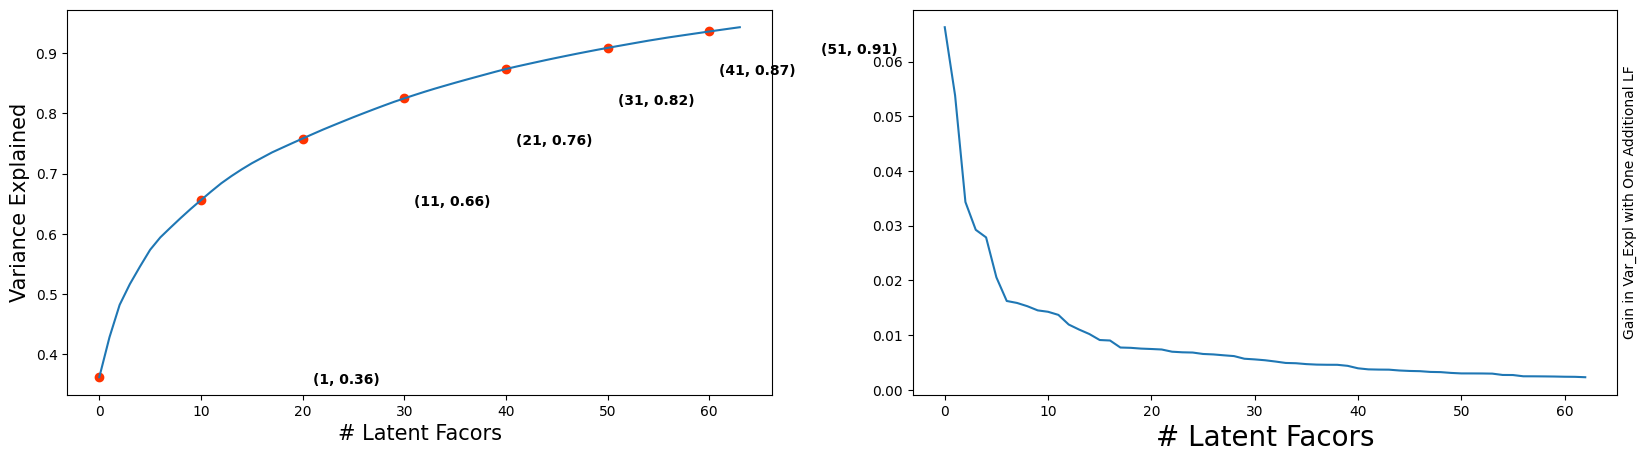

In [ ]:
expl_var = np.cumsum(dict_dim_reduction['RESOURCE_ROLE_ROLLUP_1'].explained_variance_ratio_)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize= (20,5))#figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
#ind = [1, 2, 4, 8, 20, 60, 100, 200, 300, 400, 500]
#ind = range(1, int(np.round(len(expl_var)/2)), 5 )
ind = range(1, len(expl_var), 10)
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate("({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)

ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [ ]:
del [dict_Vectorizer, dict_dim_reduction]
gc.collect()

36453

In [ ]:
# For each keys get the dim(no of components) that can explain variation ratios of 0.95
n_componets_dim = {}
end_dataset_dim = 0
for key in dict_dim_reduction.keys():
    n_componets_dim[key] = select_n_components(dict_dim_reduction[key].explained_variance_ratio_, 0.95)
    end_dataset_dim += n_componets_dim[key]
n_componets_dim

{'RESOURCE_ROLE_ROLLUP_1': 28,
 'RESOURCE_ROLE_ROLLUP_2': 28,
 'RESOURCE_ROLE_DEPTNAME': 28,
 'RESOURCE_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_FAMILY': 28,
 'RESOURCE_ROLE_CODE': 28,
 'RESOURCE_RESOURCE_ROLE_ROLLUP_1': 28,
 'RESOURCE_RESOURCE_ROLE_ROLLUP_2': 28,
 'RESOURCE_RESOURCE_ROLE_DEPTNAME': 28,
 'RESOURCE_RESOURCE_ROLE_FAMILY_DESC': 28,
 'RESOURCE_RESOURCE_ROLE_FAMILY': 28,
 'RESOURCE_RESOURCE_ROLE_CODE': 28,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_ROLLUP_2': 28,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_DEPTNAME': 28,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_FAMILY': 28,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_CODE': 28,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_DEPTNAME': 28,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_FAMILY': 28,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_CODE': 28,
 'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY_DESC': 28,
 'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY': 28,
 'RESOURCE_ROLE_DEPTNAME_ROLE_CODE': 28,
 'RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY': 28,
 'R

In [ ]:
end_dataset_dim

20168

***Note:*** 
* Most of the feature require 28 component to represent 95% of varaince in the data. If we conside that the total number of feature would be 20168.

lets check how much varaince can single component explain.

In [ ]:
#Print the varaince explained by top 1 component
top_1_var_explained = [] 
for key in dict_dim_reduction.keys():
    top_1_var_explained.append(dict_dim_reduction[key].explained_variance_ratio_[0])

top_1_var_explained

[0.3620056318969609,
 0.10855297052872862,
 0.02302979731883007,
 0.16692192848167187,
 0.26447797495465286,
 0.12238116564532149,
 0.0036287874478403664,
 0.006719233039712011,
 0.0041111707075139805,
 0.006145471381865004,
 0.005934211336472063,
 0.0049273551520804485,
 0.082264510016703,
 0.021464296021664445,
 0.13214512579126286,
 0.20235800714917349,
 0.10886603110200084,
 0.02965370414264095,
 0.05115019604200299,
 0.06091147402838949,
 0.04493386684645556,
 0.023257085360366636,
 0.023888097946718864,
 0.019095944993776138,
 0.17169429148506832,
 0.12076146195506654,
 0.15131093708753815,
 0.018407049748441918,
 0.05220854693585229,
 0.099800029556952,
 0.05588056981761778,
 0.22875352860075904,
 0.1532822702931999,
 0.009112504234022286,
 0.038129438901491765,
 0.056331372216694486,
 0.05079181292190717,
 0.11269097332260788,
 0.07898491809082896,
 0.021802830238728588,
 0.02377848059767581,
 0.011424053595926832,
 0.008061934603923399,
 0.00828884158308326,
 0.031873432643720

In [ ]:
#By default numpy sort return in assending order. So to reverse the order used flip
# np.flip(np.sort(top_1_var_explained))

array([0.39075723, 0.38982316, 0.38916919, 0.37955383, 0.37381627,
       0.36774267, 0.36200563, 0.35937939, 0.35886896, 0.3385911 ,
       0.31671812, 0.31086295, 0.31001309, 0.30978438, 0.30512735,
       0.28827929, 0.28827929, 0.27791925, 0.26667234, 0.26447797,
       0.26110113, 0.25219708, 0.25076381, 0.24216068, 0.22875353,
       0.22416179, 0.22051031, 0.21875206, 0.20235801, 0.18948369,
       0.18604512, 0.18591851, 0.18577571, 0.1836925 , 0.18202168,
       0.1806721 , 0.17812288, 0.17264924, 0.17169429, 0.16773512,
       0.16716145, 0.16692193, 0.16395751, 0.162272  , 0.16149132,
       0.15863644, 0.15774523, 0.15739335, 0.15458372, 0.15328227,
       0.15321421, 0.15196155, 0.15131094, 0.15099505, 0.15096131,
       0.14982447, 0.14894088, 0.1465227 , 0.1465227 , 0.14213965,
       0.13993418, 0.13959889, 0.13919716, 0.13848023, 0.13800847,
       0.13390611, 0.13286425, 0.13214513, 0.12812099, 0.12812099,
       0.12799141, 0.12677893, 0.12656311, 0.12604645, 0.12520

In [ ]:
i = 0
features_20_variance = []
var = 0.2

for key in dict_dim_reduction.keys():
    if dict_dim_reduction[key].explained_variance_ratio_[0] >= var:
        features_20_variance.append(key)
        i+=1

print(f'Number of new output feature with the varaiance of {var}: {i}.')

Number of new output feature with the varaiance of 0.2: 29.


In [ ]:
set_final_col_explains_require_var = set()

for col1, col2 in permutations(train.columns, 2):

    if (col1 == targetcol) | (col2 == targetcol):
        continue

    key = col1 + "_" + col2
    if key in features_20_variance:
        set_final_col_explains_require_var.add(col1)
        set_final_col_explains_require_var.add(col2)

set_final_col_explains_require_var

{'RESOURCE',
 'RESOURCE_ROLE_CODE',
 'RESOURCE_ROLE_DEPTNAME',
 'RESOURCE_ROLE_FAMILY',
 'RESOURCE_ROLE_FAMILY_DESC',
 'RESOURCE_ROLE_ROLLUP_1',
 'RESOURCE_ROLE_ROLLUP_2',
 'ROLE_CODE',
 'ROLE_DEPTNAME',
 'ROLE_DEPTNAME_ROLE_CODE',
 'ROLE_DEPTNAME_ROLE_FAMILY',
 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY_DESC_ROLE_CODE',
 'ROLE_FAMILY_DESC_ROLE_FAMILY',
 'ROLE_FAMILY_ROLE_CODE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
 'ROLE_ROLLUP_1_ROLE_FAMILY',
 'ROLE_ROLLUP_1_ROLE_FAMILY_DESC',
 'ROLE_ROLLUP_2',
 'ROLE_ROLLUP_2_ROLE_CODE',
 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
 'ROLE_ROLLUP_2_ROLE_FAMILY',
 'ROLE_ROLLUP_2_ROLE_FAMILY_DESC'}

***Note:*** 
* Varaince explained by most of the feature is not good. 
* Top 29 feature that explain varaiance with one component is about 2%. which is very low.
* When tried permutations of features with also resulted in too many output feature after dim reduction that explain the varaiance at least 80%

So instead lets consider combination of feature used for FeatureEncode with RESOURCE feature.

#### TFIDF with combination of other feature with RESOURCE #### 

In [ ]:
del [dict_Vectorizer, dict_dim_reduction]
gc.collect()

38

In [ ]:
dict_Vectorizer = {}
dict_dim_reduction = {}

col_use = ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE', 'ROLE_ROLLUP_1_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_DEPTNAME', 'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC', 'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE']
col1 = 'RESOURCE'

for col2 in col_use:
    extract_col_interaction(train, col1, col2, tfif = True)

#for col1, col2 in combinations(train[col_use], 2):    
#    extract_col_interaction(train, col1, col2, tfif = True)

Vectorize of RESOURCE & ROLE_ROLLUP_1 shape: (7518, 128), reduce to 64
Vectorize of RESOURCE & ROLE_ROLLUP_2 shape: (7518, 177), reduce to 88
Vectorize of RESOURCE & ROLE_DEPTNAME shape: (7518, 449), reduce to 224
Vectorize of RESOURCE & ROLE_FAMILY_DESC shape: (7518, 2358), reduce to 1179
Vectorize of RESOURCE & ROLE_FAMILY shape: (7518, 67), reduce to 34
Vectorize of RESOURCE & ROLE_CODE shape: (7518, 343), reduce to 172
Vectorize of RESOURCE & ROLE_ROLLUP_1_ROLE_DEPTNAME shape: (7518, 577), reduce to 288
Vectorize of RESOURCE & ROLE_ROLLUP_2_ROLE_DEPTNAME shape: (7518, 626), reduce to 313
Vectorize of RESOURCE & ROLE_ROLLUP_2_ROLE_CODE shape: (7518, 520), reduce to 260
Vectorize of RESOURCE & ROLE_DEPTNAME_ROLE_FAMILY_DESC shape: (7518, 2805), reduce to 1402
Vectorize of RESOURCE & ROLE_DEPTNAME_ROLE_FAMILY shape: (7518, 515), reduce to 258
Vectorize of RESOURCE & ROLE_DEPTNAME_ROLE_CODE shape: (7518, 792), reduce to 396


In [ ]:
len(dict_Vectorizer)

12

In [ ]:
expl_var[[1,3]]

array([0.04174374, 0.07854711])

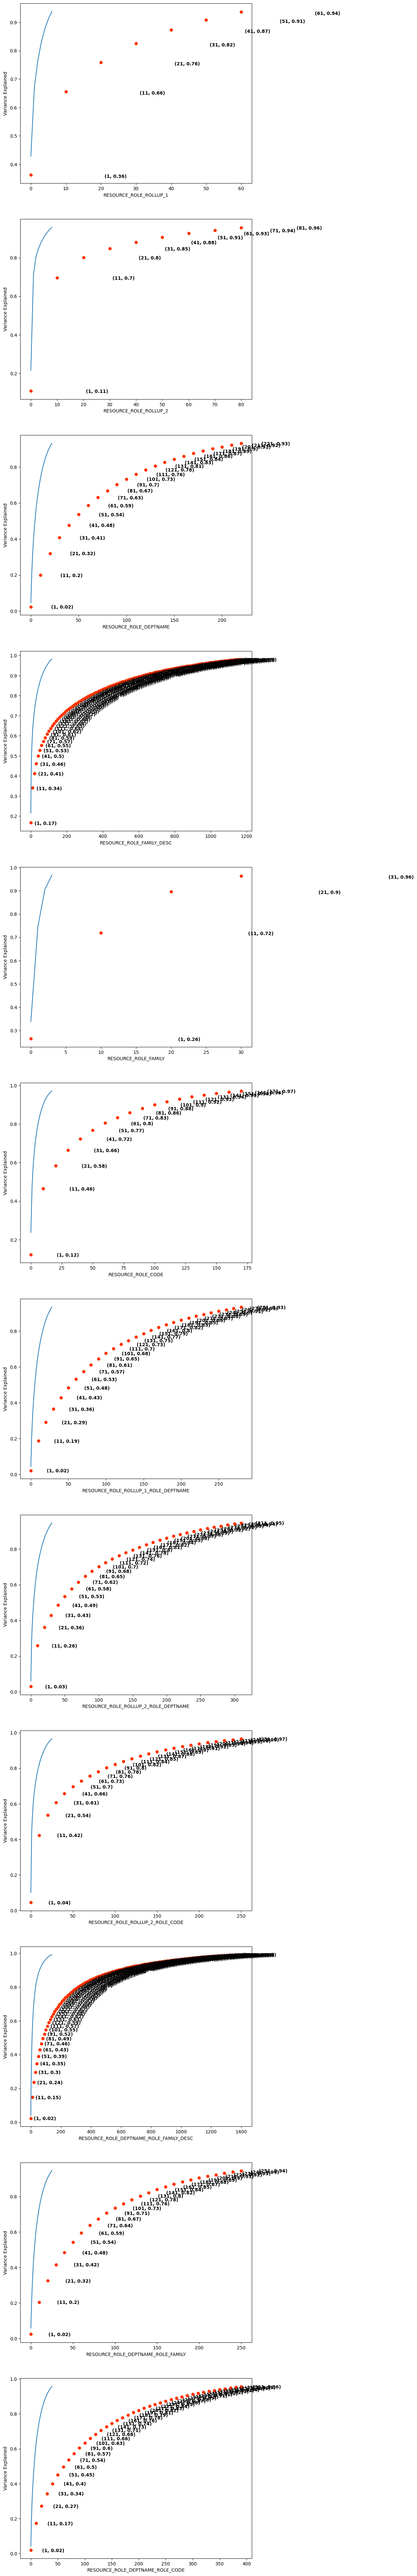

In [ ]:
fig, ax = plt.subplots(nrows = len(dict_Vectorizer), ncols = 1, figsize = (9, 100)) #figsize=plt.figaspect(.5))
keys = list(dict_Vectorizer.keys())


for key_index in range(len(keys)):

    key = keys[key_index] #dict_dim_reduction['RESOURCE_ROLE_ROLLUP_1']
    expl_var = np.cumsum(dict_dim_reduction[key].explained_variance_ratio_)

    ax1 = ax[key_index] #ax[key_index, 0]

    # annote some (latentfactors, expl_var) to make it clear
    #ind = [1, 2, 4, 8, 20, 60, 100, 200, 300, 400, 500]
    #ind = range(1, int(np.round(len(expl_var)/2)), 5 )
    ind = range(1, len(expl_var), 10)
    ax1.plot(expl_var[ind])
    ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c ='#ff3300')
    for i in ind:
        ax1.annotate("({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                    xytext = ( i+20, expl_var[i-1] - 0.01), fontweight = 'bold')
    ax1.set_ylabel("Variance Explained")#, fontsize = 15
    ax1.set_xlabel(key)
    #ax1.set_xlabel("# Latent Facors", fontsize = 15)

    """
    ax2 = ax[key_index, 1]
    change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
    ax2.plot(change_in_expl_var)

    ax2.set_ylabel("Gain in Var_Expl with One Additional LF")#, fontsize=10
    ax2.yaxis.set_label_position("right")
    #ax2.set_xlabel("# Latent Facors", fontsize=20)
    ax2.set_xlabel(key)
    """

plt.show()

**Note**
We shall consider only those component that explain the varaince by least 80%

In [ ]:
n_componets_dim = {}
end_dataset_dim = 0
for key in dict_dim_reduction.keys():
    n_componets_dim[key] = select_n_components(dict_dim_reduction[key].explained_variance_ratio_, 0.80)
    end_dataset_dim += n_componets_dim[key]
n_componets_dim

{'RESOURCE_ROLE_ROLLUP_1': 27,
 'RESOURCE_ROLE_ROLLUP_2': 21,
 'RESOURCE_ROLE_DEPTNAME': 129,
 'RESOURCE_ROLE_FAMILY_DESC': 328,
 'RESOURCE_ROLE_FAMILY': 15,
 'RESOURCE_ROLE_CODE': 60,
 'RESOURCE_ROLE_ROLLUP_1_ROLE_DEPTNAME': 160,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_DEPTNAME': 154,
 'RESOURCE_ROLE_ROLLUP_2_ROLE_CODE': 90,
 'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY_DESC': 317,
 'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY': 130,
 'RESOURCE_ROLE_DEPTNAME_ROLE_CODE': 186}

In [ ]:
#Total feature after this transormation
#sum(n_componets_dim.values())
np.sum(np.array(list(n_componets_dim.values())))

1617

**Observation:**
When applied tfidf logic used only those feature that explain variance by 90% using less then 100 component:
    - Time to compute using  CPU resource was too long.
    - Result output was poor then when used log transfomed frequecny encoder. 

### Binning RESOURCE using other columns ###

Selecting those columns and encode RESOURCE such the the encode value has both +ve and -ve class lable.
RESOURCE has too many unique value, when group to resource based on certain roles could be helpfull.

In [36]:
train.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')

In [38]:
targetcol = 'ACTION'
col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
train = train[col_use]
col_use

['ACTION',
 'RESOURCE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [39]:
def combine_cols( columns):

    for c1,c2 in combinations(columns, 2): #permutations #Number of unique count where same i.e col1_col2 == col2_col1
    
        if (c1 == targetcol) | (c2 == targetcol):
            continue

        name = "{}_{}".format(c1, c2)

        train[name] = train[c1] + " " + train[c2]

col_use.remove('RESOURCE')
combine_cols(col_use)
train.columns

Index(['ACTION', 'RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE'],
      dtype='object')

In [40]:
#train = train.merge(train.groupby('ROLE_ROLLUP_1').RESOURCE.nunique().reset_index(name = 'resource_role_rollup_1_enc'), on ='ROLE_ROLLUP_1', how = 'inner')
#temp = train.groupby('resource_role_rollup_1_enc').ACTION.mean().reset_index(name = 'action_mean')
#print(f'resource_role_rollup_1_enc: Total number of records {temp.shape[0]}')
#print(f'resource_role_rollup_1_enc: Total number of records with mean not equal to 1 {temp[temp.action_mean!=1].shape[0]}')

def encode_resource_by_feature(X):

    column_to_consider = ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
                        'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
                        'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
                        'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
                        'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
                        'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
                        'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
                        'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
                        'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
                        'ROLE_FAMILY_ROLE_CODE'
                        ]

    for col in column_to_consider:
        
        new_col_name = 'resource_'+ col.lower() + "_enc"
        X = X.merge(X.groupby(col).RESOURCE.nunique().reset_index(name = new_col_name), on = col, how = 'inner')

        #Output how will can target encoded resource by col be used.
        temp = X.groupby(new_col_name).ACTION.mean().reset_index(name = 'action_mean')
        print(f'{new_col_name}: Total number of records {temp.shape[0]}')
        print(f'{new_col_name}: Total number of records with mean not equal to 1: {temp[temp.action_mean!=1].shape[0]}')


    return X

train = encode_resource_by_feature(train)

#train.columns

resource_role_rollup_1_enc: Total number of records 71
resource_role_rollup_1_enc: Total number of records with mean not equal to 1: 60
resource_role_rollup_2_enc: Total number of records 82
resource_role_rollup_2_enc: Total number of records with mean not equal to 1: 73
resource_role_deptname_enc: Total number of records 119
resource_role_deptname_enc: Total number of records with mean not equal to 1: 115
resource_role_family_desc_enc: Total number of records 97
resource_role_family_desc_enc: Total number of records with mean not equal to 1: 87
resource_role_family_enc: Total number of records 54
resource_role_family_enc: Total number of records with mean not equal to 1: 45
resource_role_code_enc: Total number of records 110
resource_role_code_enc: Total number of records with mean not equal to 1: 98
resource_role_rollup_1_role_rollup_2_enc: Total number of records 82
resource_role_rollup_1_role_rollup_2_enc: Total number of records with mean not equal to 1: 73
resource_role_rollup_1_

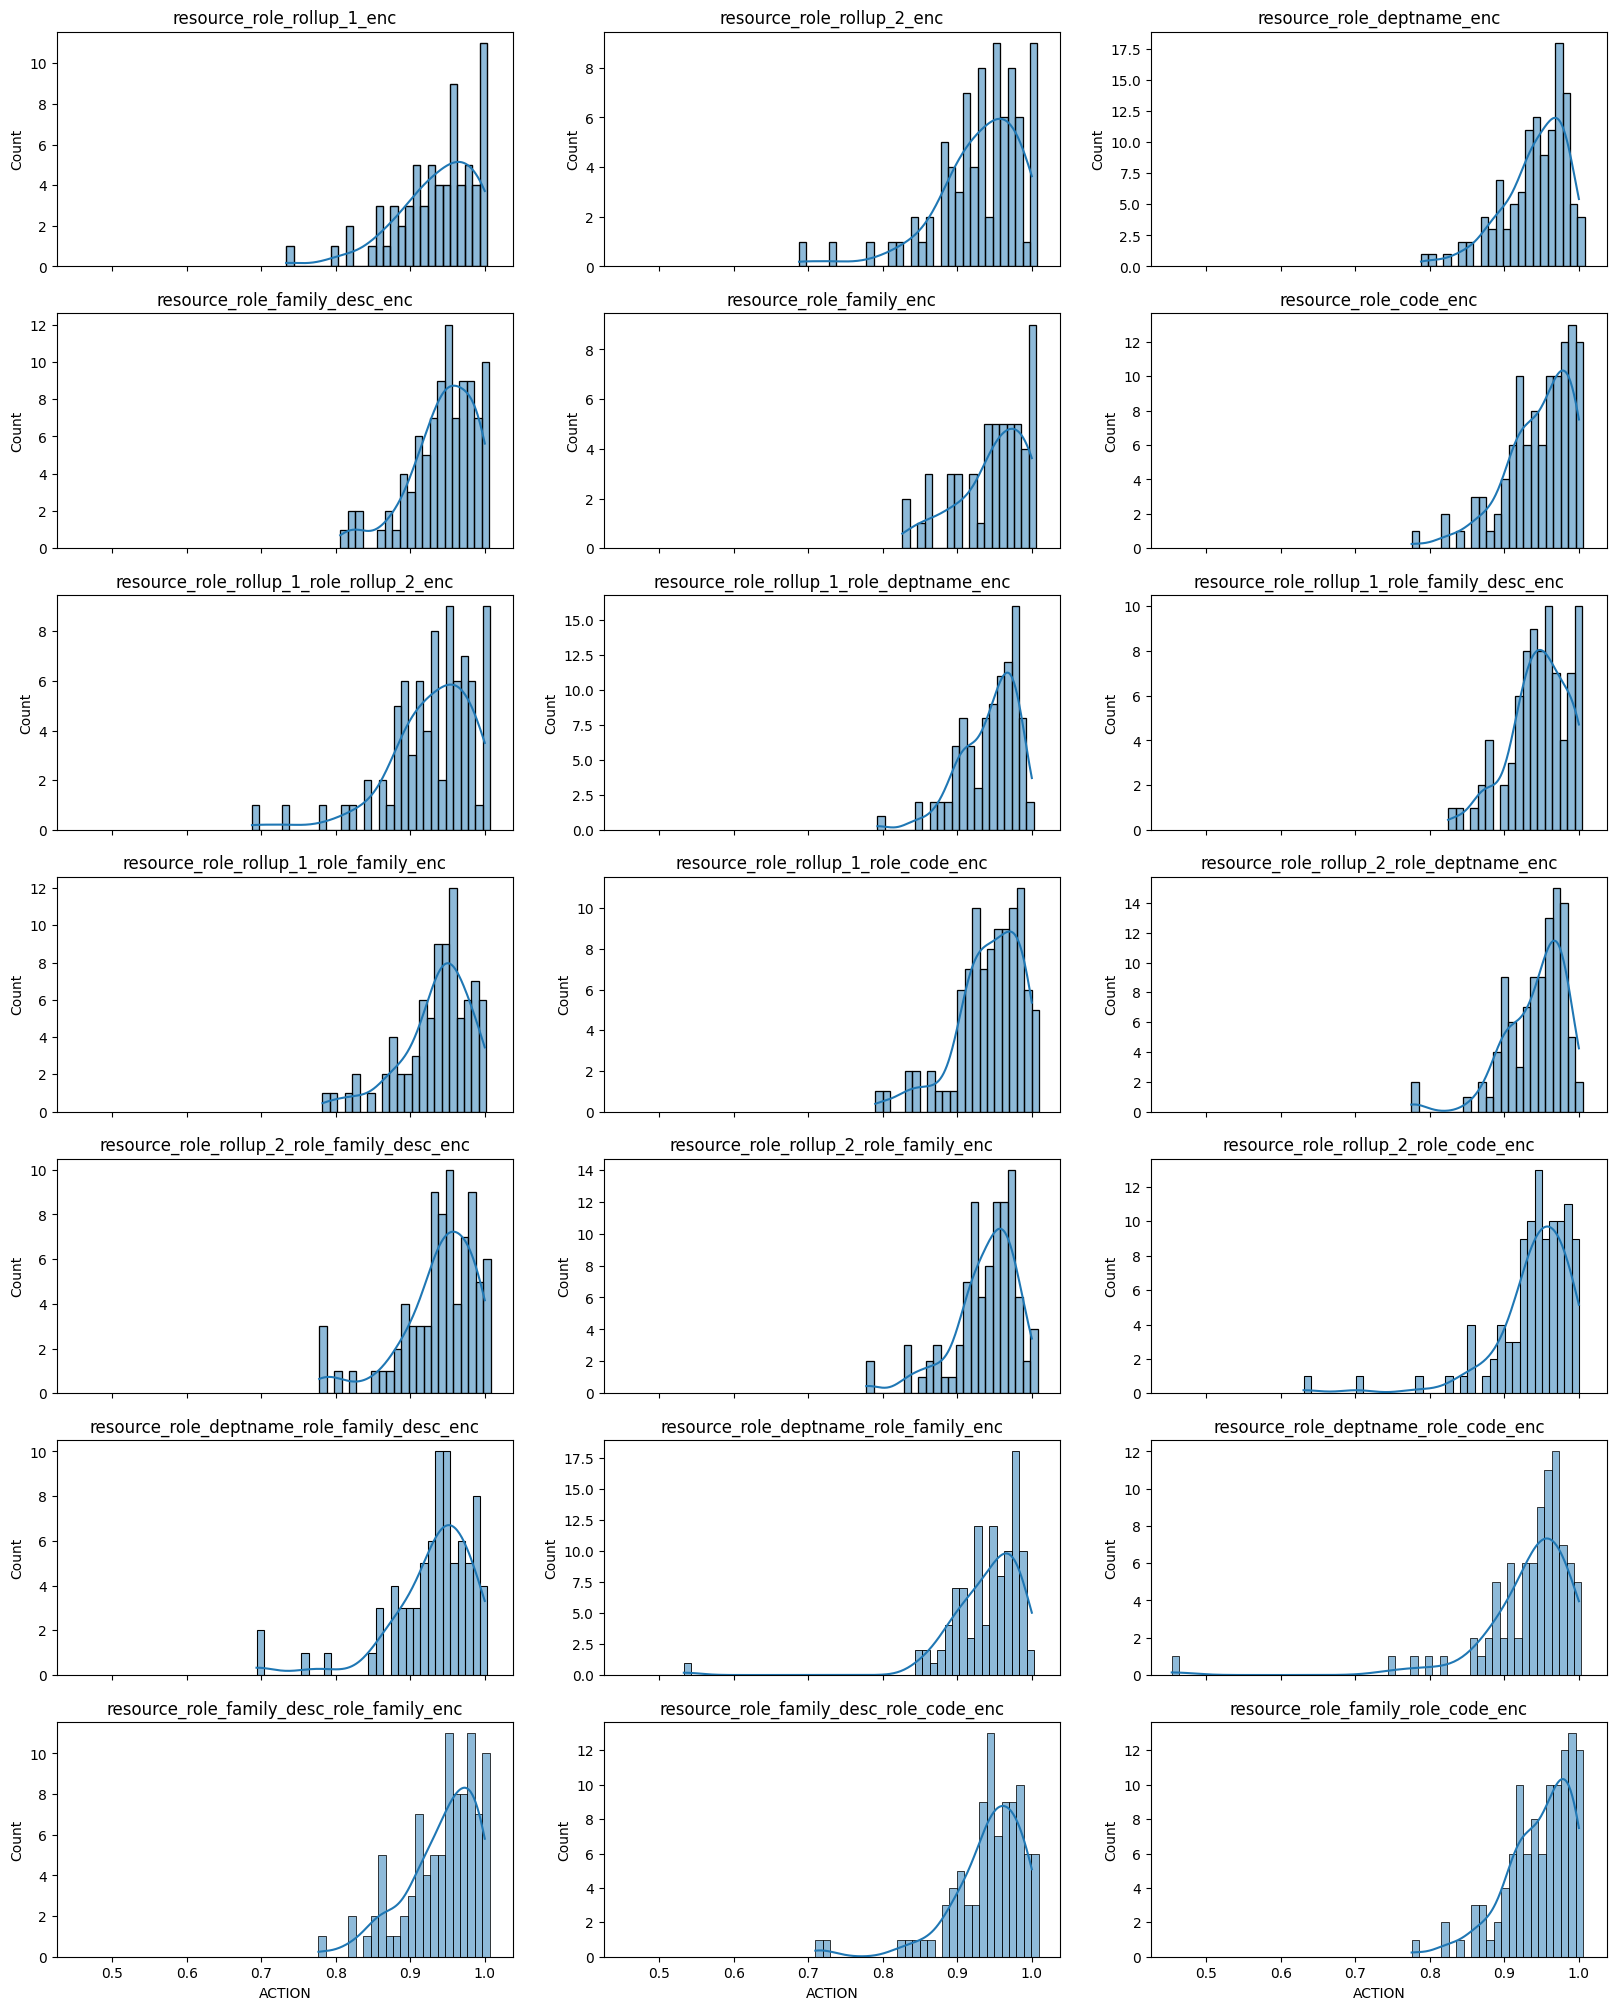

In [83]:
resource_enc_col = [col for col in train.columns if '_enc' in col]

fig, ax = plt.subplots(nrows = 7, ncols = 3, sharex = True, figsize = (20, 25))

index = 0
for row in range(0, 7):

    for col in range(0, 3):
        if index < len(resource_enc_col):

            x = sns.histplot(train.groupby(resource_enc_col[index]).ACTION.mean(), kde = True, binwidth = 0.01, ax = ax[row][col])
            x.set_title(resource_enc_col[index]) #set_xlabel
            #x.set_ylabel('ACTION means')
            index +=1
        else:
            break
    
    if index > len(resource_enc_col):
        break
    
plt.show()

#sns.histplot(train.groupby('resource_role_rollup_1_role_deptname_enc').ACTION.mean(), kde = True, binwidth = 0.01)

**Observation**

- We shall not consider records where number of records with mean on 1 is very large.

- RESOURCE when encode with other feature result in the mean not equal to 1 is less

<table>
<tr>
    <th>Feature Name</th>
    <th>Total records</th>
    <th>Mean less then one</th>
</tr>
<tr>
    <td>resource_role_rollup_1_role_deptname_enc</td>
    <td>98</td>
    <td>97</td>
</tr>
<tr>
    <td>resource_role_rollup_1_role_code_enc</td>
    <td>99</td>
    <td>94</td>
</tr>
<tr>
    <td>resource_role_rollup_2_role_deptname_enc</td>
    <td>102</td>
    <td>101</td>
</tr>
<tr>
    <td>resource_role_rollup_2_role_family_enc</td>
    <td>99</td>
    <td>95</td>
</tr>
<tr>
    <td>resource_role_deptname_role_family_enc</td>
    <td>105</td>
    <td>103</td>
</tr>
</table>

-  resource_role_rollup_2_role_deptname_enc & resource_role_rollup_1_role_deptname_enc least mean 1 but have too many records in range of 0.95 - 0.98.
-  resource_role_deptname_role_family_enc has least mean and seen a good dstrubution.


In [86]:
train[['ACTION','RESOURCE','resource_role_deptname_role_family_enc']]

ACTION RESOURCE  resource_role_deptname_role_family_enc
0           1    39353                                      46
1           1    42093                                      46
2           1    78240                                      46
3           1    79092                                      46
4           1    23187                                      46
...       ...      ...                                     ...
30386       1    75078                                       2
30387       1    73815                                       2
30388       1    73815                                       2
30389       1    73815                                       2
30390       1    25993                                       1

[30391 rows x 3 columns]